In [1]:
from keras.utils import to_categorical
from keras.optimizers import Adam, Adadelta, SGD
from keras.models import Sequential
from keras.layers import Dense, Activation, Conv2D, MaxPool2D, Dropout, Flatten, Conv1D, GlobalAveragePooling1D, Convolution1D
from keras.layers.convolutional import MaxPooling2D, MaxPooling1D
from keras.models import load_model
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.utils import class_weight
from scipy import signal
from glob import glob
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

c:\users\sebastiaan\appdata\local\programs\python\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# constants:
SUBSAMPLE = 10  # scales the data by this factor
COLUMNS = ['HandStart', 'FirstDigitTouch',
        'BothStartLoadPhase', 'LiftOff',
        'Replace', 'BothReleased']
TRAIN_SUBJECTS = range(9, 13)
TEST_SUBJECTS = range(9, 13)
N_LABELS = 6

# Below are the paths to the data. Please pay attention to the % and * signs, these are needed in the loop.
TRAIN_DATA_PATH = 'C:/Users/Sebastiaan/Desktop/Programming/MachineLearning/Datasets/EEG/train/subj%d_series*_data.csv'
# TRAIN_DATA_PATH = 'C:/Users/bas/Documents/MachineLearning/train/subj%d_series*_data.csv'

EPOCHS = 100
WINDOW_SIZE = 2000
SPLIT_SIZE = 50
BATCH_SIZE = 10

In [3]:
def prepare_training_data(data_path):
    data = pd.read_csv(data_path)
    event_path = data_path.replace('_data', '_events')
    labels = pd.read_csv(event_path)
    clean_data = data.drop(['id'], axis = 1)
    labels = labels.drop(['id'], axis = 1)
    return clean_data, labels

In [4]:
def preprocess_data(x_raw, WINDOW_SIZE, subsample):
    x_raw, scaler = scaler_transform(x_raw[::subsample], None)
    x_raw = image_mappping(x_raw, WINDOW_SIZE)
    return x_raw, scaler

In [5]:
def scaler_transform(data, scaler):
    if scaler == None:
        scaler = Normalizer()
        return scaler.fit_transform(data), scaler
    else:
        return scaler.transform(data)   

In [6]:
def read_training_data(train_data_paths):
    labels_raw = []
    features_raw = []
    for data_path in train_data_paths:
        data, labels = prepare_training_data(data_path)
        features_raw.append(data)
        labels_raw.append(labels)
    features_raw = pd.concat(features_raw)
    labels_raw = pd.concat(labels_raw)
    x_train = np.asarray(features_raw.astype(float))
    y_train = np.asarray(labels_raw.astype(float))
    return x_train, y_train

In [7]:
def metric_auc_score(predictions, y_test, with_plot):
    scores = []
    legend_text = []
    for i in range(N_LABELS):
        fpr, tpr, _  = roc_curve(y_test[:,i], predictions[:,i], 1)
        scores.append(roc_auc_score(y_test[:,i], predictions[:,i]))
        legend_text.append(COLUMNS[i]+' (area = %.3f)' % (scores[i]))
        if with_plot == True:
            plt.plot(fpr, tpr)
    if with_plot == True:
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curves')
        plt.legend(legend_text)
        plt.show()
    return scores

In [8]:
def multiple_metric_auc_score(prediction_total, test_data_total, with_plot):
    legend_text = []
    counter = 0
    for i in range(len(prediction_total)):
        fpr, tpr, _  = roc_curve(test_data_total[i], prediction_total[i], pos_label=1)
        score = roc_auc_score(test_data_total[i],prediction_total[i])
        legend_text.append(COLUMNS[i]+' (area = %.3f)' % (score))
        print(COLUMNS[i]+' AUC score = %.3f' % (score))
        plt.plot(fpr, tpr)
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curves')
        plt.legend(legend_text)
    plt.show()

In [9]:
def single_metric_auc_score(predictions, y_test, with_plot, i):
    fpr, tpr, _  = roc_curve(y_test, predictions, 1)
    score = roc_auc_score(y_test, predictions)
    print(COLUMNS[i]+' AUC score = %.3f' % (score))
    if with_plot == True:
        plt.plot(fpr, tpr)
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curves')
        plt.show()
    return score

In [10]:
def all_auc_scores(prediction_total, test_data_total, subjects, with_plot):
    scores = []
    for subject in subjects:
        score = metric_auc_score(prediction_total[subject-1],
                                 test_data_total[subject-1], with_plot)
        scores.append(score)
        print('Mean AUC Score of Subject %d: %.3f' % \
              (subject, np.mean(score)))
    return scores

In [11]:
def image_mappping(x_train, WINDOW_SIZE):
    result = []
    empty_matrix = np.zeros(np.shape(x_train[0:WINDOW_SIZE]))
    for i in range(len(x_train)):
        if i-WINDOW_SIZE < 0:
            result.append(empty_matrix)
        else:
            result.append(x_train[i-WINDOW_SIZE:i])
    return result

In [12]:
def resample_and_shuffle(labels):
    when_task = np.where(labels == 1)
    when_no_task = np.where(labels == 0)
    when_no_task = when_no_task[0][0:len(when_task[0])]
    indices = np.concatenate([when_task[0], when_no_task])
    np.random.shuffle(indices)
    return indices

In [13]:
def balance_set(indices, x_train, y_train):
    balance_x = []
    balance_y = []
    for index in indices:
        balance_x.append(x_train[index])
        balance_y.append(y_train[index])
    return balance_x, balance_y

In [14]:
def remove_imbalance(x_train, y_train):
    indices = resample_and_shuffle(y_train)
    balanced_x_train, balanced_y_train = balance_set(indices, x_train, y_train)
    return balanced_x_train, balanced_y_train

In [15]:
def predict_on_sub(x_test, model, split_size, batch_size):
    split_size = int(len(x_test) / split_size)
    sub_x_test = x_test[1000::batch_size]
    batch = []
    predictions = np.array([])
    for i in range(len(sub_x_test)):
        batch.append(sub_x_test[i])
        if i+1 == len(sub_x_test):
            return np.concatenate([predictions, model.predict(np.array(batch))[:,1]])
        elif (i+1) % split_size == 0:
            predictions = np.concatenate([predictions, model.predict(np.array(batch))[:,1]])
            batch = []

In [16]:
def init_cnn(window):
    model = Sequential()
    model.add(Conv1D(nb_filter=16, filter_length=3, activation='relu', input_shape=(window, 32)))
    model.add(MaxPooling1D(3,2))
    model.add(Conv1D(nb_filter=32, filter_length=3, activation='relu'))
    model.add(Conv1D(nb_filter=64, filter_length=3, activation='relu'))
    model.add(MaxPooling1D(3,2))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(2, activation='softmax'))
#     model.summary()
    
    optimizer = SGD(lr=0.001, momentum=0.0, decay=0.0, nesterov=False)
#     optimizer = Adam(lr=1e-6)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead
47768 47768
Train subject 9, class HandStart
Train on 1752 samples, validate on 438 samples
Epoch 1/100
1752/1752 [==============================] - 6s 4ms/step - loss: 0.6908 - acc: 0.5285 - val_loss: 0.6920 - val_acc: 0.5046
Epoch 2/100
1752/1752 [==============================] - 3s 2ms/step - loss: 0.6926 - acc: 0.5183 - val_loss: 0.6899 - val_acc: 0.5685
Epoch 3/100
1752/1752 [==============================] - 3s 2ms/step - loss: 0.6883 - acc: 0.5342 - val_loss: 0.6874 - val_acc: 0.6370
Epoch 4/100
1752/1752 [==============================] - 3s 2ms/step - loss: 0.6886 - acc: 0.5428 - val_loss: 0.6861 - val_acc: 0.6164
Epoch 5/100
1752/1752 [==============================] - 3s 2ms/step - loss: 0.6846 - acc: 0.5485 - val_loss: 0.6838 - val_acc: 0.6438
Epoch 6/100
1752/1752 [==============================] - 3s 2ms/step - loss: 0.6852 - acc: 0.5616 - val_loss: 0.6819 - val_acc: 0.6598
Epoch 7/100
175

1752/1752 [==============================] - 3s 2ms/step - loss: 0.3971 - acc: 0.8356 - val_loss: 0.3975 - val_acc: 0.8356
Epoch 59/100
1752/1752 [==============================] - 3s 2ms/step - loss: 0.3921 - acc: 0.8253 - val_loss: 0.4099 - val_acc: 0.8265
Epoch 60/100
1752/1752 [==============================] - 3s 2ms/step - loss: 0.4008 - acc: 0.8248 - val_loss: 0.3975 - val_acc: 0.8288
Epoch 61/100
1752/1752 [==============================] - 3s 2ms/step - loss: 0.3940 - acc: 0.8242 - val_loss: 0.3927 - val_acc: 0.8356
Epoch 62/100
1752/1752 [==============================] - 3s 2ms/step - loss: 0.3924 - acc: 0.8385 - val_loss: 0.3910 - val_acc: 0.8356
Epoch 63/100
1752/1752 [==============================] - 3s 2ms/step - loss: 0.3807 - acc: 0.8379 - val_loss: 0.3998 - val_acc: 0.8356
Epoch 64/100
1752/1752 [==============================] - 3s 2ms/step - loss: 0.3793 - acc: 0.8362 - val_loss: 0.3876 - val_acc: 0.8356
Epoch 65/100
1752/1752 [==============================] - 3s 

1752/1752 [==============================] - 3s 2ms/step - loss: 0.3358 - acc: 0.8522 - val_loss: 0.3107 - val_acc: 0.8858
Epoch 19/100
1752/1752 [==============================] - 3s 2ms/step - loss: 0.3245 - acc: 0.8659 - val_loss: 0.3132 - val_acc: 0.8813
Epoch 20/100
1752/1752 [==============================] - 3s 2ms/step - loss: 0.3244 - acc: 0.8687 - val_loss: 0.3051 - val_acc: 0.8858
Epoch 21/100
1752/1752 [==============================] - 3s 2ms/step - loss: 0.3240 - acc: 0.8664 - val_loss: 0.3066 - val_acc: 0.8904
Epoch 22/100
1752/1752 [==============================] - 3s 2ms/step - loss: 0.3330 - acc: 0.8602 - val_loss: 0.3091 - val_acc: 0.8790
Epoch 23/100
1752/1752 [==============================] - 3s 2ms/step - loss: 0.3260 - acc: 0.8630 - val_loss: 0.3009 - val_acc: 0.8881
Epoch 24/100
1752/1752 [==============================] - 3s 2ms/step - loss: 0.3183 - acc: 0.8773 - val_loss: 0.2995 - val_acc: 0.8858
Epoch 25/100
1752/1752 [==============================] - 3s 

1752/1752 [==============================] - 3s 2ms/step - loss: 0.2562 - acc: 0.8984 - val_loss: 0.2570 - val_acc: 0.9018
Epoch 79/100
1752/1752 [==============================] - 3s 2ms/step - loss: 0.2434 - acc: 0.8927 - val_loss: 0.2690 - val_acc: 0.8950
Epoch 80/100
1752/1752 [==============================] - 3s 2ms/step - loss: 0.2488 - acc: 0.8955 - val_loss: 0.2579 - val_acc: 0.9018
Epoch 81/100
1752/1752 [==============================] - 3s 2ms/step - loss: 0.2496 - acc: 0.9041 - val_loss: 0.2519 - val_acc: 0.9041
Epoch 82/100
1752/1752 [==============================] - 3s 2ms/step - loss: 0.2455 - acc: 0.9047 - val_loss: 0.2593 - val_acc: 0.8995
Epoch 83/100
1752/1752 [==============================] - 3s 2ms/step - loss: 0.2448 - acc: 0.8984 - val_loss: 0.2532 - val_acc: 0.9041
Epoch 84/100
1752/1752 [==============================] - 3s 2ms/step - loss: 0.2394 - acc: 0.9075 - val_loss: 0.2616 - val_acc: 0.8995
Epoch 85/100
1752/1752 [==============================] - 3s 

1751/1751 [==============================] - 3s 2ms/step - loss: 0.4604 - acc: 0.8224 - val_loss: 0.4654 - val_acc: 0.8242
Epoch 38/100
1751/1751 [==============================] - 3s 2ms/step - loss: 0.4479 - acc: 0.8321 - val_loss: 0.4512 - val_acc: 0.8265
Epoch 39/100
1751/1751 [==============================] - 3s 2ms/step - loss: 0.4322 - acc: 0.8287 - val_loss: 0.4385 - val_acc: 0.8402
Epoch 40/100
1751/1751 [==============================] - 3s 2ms/step - loss: 0.4253 - acc: 0.8355 - val_loss: 0.4283 - val_acc: 0.8425
Epoch 41/100
1751/1751 [==============================] - 3s 2ms/step - loss: 0.4113 - acc: 0.8367 - val_loss: 0.4195 - val_acc: 0.8493
Epoch 42/100
1751/1751 [==============================] - 3s 2ms/step - loss: 0.4027 - acc: 0.8412 - val_loss: 0.4162 - val_acc: 0.8379
Epoch 43/100
1751/1751 [==============================] - 3s 2ms/step - loss: 0.3894 - acc: 0.8481 - val_loss: 0.4008 - val_acc: 0.8562
Epoch 44/100
1751/1751 [==============================] - 3s 

1751/1751 [==============================] - 3s 2ms/step - loss: 0.2088 - acc: 0.9178 - val_loss: 0.2903 - val_acc: 0.9132
Epoch 98/100
1751/1751 [==============================] - 3s 2ms/step - loss: 0.2008 - acc: 0.9275 - val_loss: 0.2906 - val_acc: 0.9132
Epoch 99/100
1751/1751 [==============================] - 3s 2ms/step - loss: 0.1901 - acc: 0.9280 - val_loss: 0.2747 - val_acc: 0.9110
Epoch 100/100
1751/1751 [==============================] - 3s 2ms/step - loss: 0.1987 - acc: 0.9280 - val_loss: 0.2807 - val_acc: 0.9132
Train on 1751 samples, validate on 438 samples
Epoch 1/100
1751/1751 [==============================] - 3s 2ms/step - loss: 0.2452 - acc: 0.9063 - val_loss: 0.2167 - val_acc: 0.9361
Epoch 2/100
1751/1751 [==============================] - 3s 2ms/step - loss: 0.2418 - acc: 0.9069 - val_loss: 0.2392 - val_acc: 0.9201
Epoch 3/100
1751/1751 [==============================] - 3s 2ms/step - loss: 0.2302 - acc: 0.9109 - val_loss: 0.2313 - val_acc: 0.9247
Epoch 4/100
1751

1751/1751 [==============================] - 3s 2ms/step - loss: 0.1303 - acc: 0.9532 - val_loss: 0.1821 - val_acc: 0.9475
Epoch 58/100
1751/1751 [==============================] - 3s 2ms/step - loss: 0.1357 - acc: 0.9532 - val_loss: 0.1920 - val_acc: 0.9452
Epoch 59/100
1751/1751 [==============================] - 3s 2ms/step - loss: 0.1300 - acc: 0.9577 - val_loss: 0.2010 - val_acc: 0.9429
Epoch 60/100
1751/1751 [==============================] - 3s 2ms/step - loss: 0.1319 - acc: 0.9555 - val_loss: 0.2085 - val_acc: 0.9406
Epoch 61/100
1751/1751 [==============================] - 3s 2ms/step - loss: 0.1353 - acc: 0.9572 - val_loss: 0.1990 - val_acc: 0.9452
Epoch 62/100
1751/1751 [==============================] - 3s 2ms/step - loss: 0.1297 - acc: 0.9583 - val_loss: 0.2120 - val_acc: 0.9406
Epoch 63/100
1751/1751 [==============================] - 3s 2ms/step - loss: 0.1309 - acc: 0.9532 - val_loss: 0.1874 - val_acc: 0.9475
Epoch 64/100
1751/1751 [==============================] - 3s 

1751/1751 [==============================] - 3s 2ms/step - loss: 0.6585 - acc: 0.6413 - val_loss: 0.6546 - val_acc: 0.6324
Epoch 17/100
1751/1751 [==============================] - 3s 2ms/step - loss: 0.6494 - acc: 0.6762 - val_loss: 0.6502 - val_acc: 0.6575
Epoch 18/100
1751/1751 [==============================] - 3s 2ms/step - loss: 0.6468 - acc: 0.6699 - val_loss: 0.6455 - val_acc: 0.6667
Epoch 19/100
1751/1751 [==============================] - 3s 2ms/step - loss: 0.6430 - acc: 0.6676 - val_loss: 0.6397 - val_acc: 0.7306
Epoch 20/100
1751/1751 [==============================] - 3s 2ms/step - loss: 0.6338 - acc: 0.7013 - val_loss: 0.6390 - val_acc: 0.6233
Epoch 21/100
1751/1751 [==============================] - 3s 2ms/step - loss: 0.6305 - acc: 0.6916 - val_loss: 0.6292 - val_acc: 0.6484
Epoch 22/100
1751/1751 [==============================] - 7s 4ms/step - loss: 0.6191 - acc: 0.7150 - val_loss: 0.6212 - val_acc: 0.6872
Epoch 23/100
1751/1751 [==============================] - 3s 

1751/1751 [==============================] - 3s 2ms/step - loss: 0.2475 - acc: 0.9023 - val_loss: 0.2596 - val_acc: 0.9110
Epoch 77/100
1751/1751 [==============================] - 3s 2ms/step - loss: 0.2380 - acc: 0.9098 - val_loss: 0.2705 - val_acc: 0.8927
Epoch 78/100
1751/1751 [==============================] - 3s 2ms/step - loss: 0.2296 - acc: 0.9206 - val_loss: 0.2663 - val_acc: 0.8995
Epoch 79/100
1751/1751 [==============================] - 3s 2ms/step - loss: 0.2363 - acc: 0.9143 - val_loss: 0.2606 - val_acc: 0.9041
Epoch 80/100
1751/1751 [==============================] - 3s 2ms/step - loss: 0.2279 - acc: 0.9160 - val_loss: 0.2628 - val_acc: 0.8995
Epoch 81/100
1751/1751 [==============================] - 3s 2ms/step - loss: 0.2326 - acc: 0.9115 - val_loss: 0.2690 - val_acc: 0.8927
Epoch 82/100
1751/1751 [==============================] - 3s 2ms/step - loss: 0.2227 - acc: 0.9115 - val_loss: 0.2616 - val_acc: 0.8995
Epoch 83/100
1751/1751 [==============================] - 3s 

1751/1751 [==============================] - 3s 2ms/step - loss: 0.1780 - acc: 0.9315 - val_loss: 0.2238 - val_acc: 0.9201
Epoch 37/100
1751/1751 [==============================] - 3s 2ms/step - loss: 0.1864 - acc: 0.9349 - val_loss: 0.2331 - val_acc: 0.9201
Epoch 38/100
1751/1751 [==============================] - 3s 2ms/step - loss: 0.1754 - acc: 0.9366 - val_loss: 0.2300 - val_acc: 0.9201
Epoch 39/100
1751/1751 [==============================] - 3s 2ms/step - loss: 0.1716 - acc: 0.9349 - val_loss: 0.2238 - val_acc: 0.9201
Epoch 40/100
1751/1751 [==============================] - 3s 2ms/step - loss: 0.1707 - acc: 0.9320 - val_loss: 0.2499 - val_acc: 0.9132
Epoch 41/100
1751/1751 [==============================] - 3s 2ms/step - loss: 0.1682 - acc: 0.9355 - val_loss: 0.2353 - val_acc: 0.9178
Epoch 42/100
1751/1751 [==============================] - 3s 2ms/step - loss: 0.1653 - acc: 0.9360 - val_loss: 0.2125 - val_acc: 0.9247
Epoch 43/100
1751/1751 [==============================] - 3s 

1751/1751 [==============================] - 3s 2ms/step - loss: 0.1242 - acc: 0.9555 - val_loss: 0.2320 - val_acc: 0.9201
Epoch 97/100
1751/1751 [==============================] - 3s 2ms/step - loss: 0.1283 - acc: 0.9537 - val_loss: 0.2394 - val_acc: 0.9247
Epoch 98/100
1751/1751 [==============================] - 3s 2ms/step - loss: 0.1281 - acc: 0.9515 - val_loss: 0.2188 - val_acc: 0.9269
Epoch 99/100
1751/1751 [==============================] - 3s 2ms/step - loss: 0.1185 - acc: 0.9566 - val_loss: 0.1955 - val_acc: 0.9361
Epoch 100/100
1751/1751 [==============================] - 3s 2ms/step - loss: 0.1184 - acc: 0.9606 - val_loss: 0.1983 - val_acc: 0.9338
Test subject 9, class BothStartLoadPhase
Train subject 9, class LiftOff
Train on 1751 samples, validate on 438 samples
Epoch 1/100
1751/1751 [==============================] - 4s 2ms/step - loss: 0.6936 - acc: 0.5106 - val_loss: 0.6908 - val_acc: 0.5753
Epoch 2/100
1751/1751 [==============================] - 3s 2ms/step - loss: 0

1751/1751 [==============================] - 3s 2ms/step - loss: 0.3810 - acc: 0.8332 - val_loss: 0.3713 - val_acc: 0.8653
Epoch 56/100
1751/1751 [==============================] - 3s 2ms/step - loss: 0.3566 - acc: 0.8498 - val_loss: 0.3589 - val_acc: 0.8630
Epoch 57/100
1751/1751 [==============================] - 3s 2ms/step - loss: 0.3555 - acc: 0.8549 - val_loss: 0.3624 - val_acc: 0.8607
Epoch 58/100
1751/1751 [==============================] - 3s 2ms/step - loss: 0.3501 - acc: 0.8527 - val_loss: 0.3479 - val_acc: 0.8721: 1s - loss: 0.3554 
Epoch 59/100
1751/1751 [==============================] - 3s 2ms/step - loss: 0.3511 - acc: 0.8452 - val_loss: 0.3440 - val_acc: 0.8744
Epoch 60/100
1751/1751 [==============================] - 3s 2ms/step - loss: 0.3521 - acc: 0.8492 - val_loss: 0.3499 - val_acc: 0.8630
Epoch 61/100
1751/1751 [==============================] - 3s 2ms/step - loss: 0.3324 - acc: 0.8635 - val_loss: 0.3423 - val_acc: 0.8676
Epoch 62/100
1751/1751 [=================

Epoch 15/100
1751/1751 [==============================] - 3s 2ms/step - loss: 0.2060 - acc: 0.9258 - val_loss: 0.2667 - val_acc: 0.8858
Epoch 16/100
1751/1751 [==============================] - 3s 2ms/step - loss: 0.2092 - acc: 0.9269 - val_loss: 0.2518 - val_acc: 0.8973
Epoch 17/100
1751/1751 [==============================] - 3s 2ms/step - loss: 0.2147 - acc: 0.9263 - val_loss: 0.2563 - val_acc: 0.8927
Epoch 18/100
1751/1751 [==============================] - 3s 2ms/step - loss: 0.2032 - acc: 0.9229 - val_loss: 0.2788 - val_acc: 0.8790
Epoch 19/100
1751/1751 [==============================] - 3s 2ms/step - loss: 0.1961 - acc: 0.9303 - val_loss: 0.2549 - val_acc: 0.8950
Epoch 20/100
1751/1751 [==============================] - 3s 2ms/step - loss: 0.1996 - acc: 0.9343 - val_loss: 0.2787 - val_acc: 0.8813
Epoch 21/100
1751/1751 [==============================] - 3s 2ms/step - loss: 0.2110 - acc: 0.9252 - val_loss: 0.2767 - val_acc: 0.8813
Epoch 22/100
1751/1751 [========================

1751/1751 [==============================] - 3s 2ms/step - loss: 0.1449 - acc: 0.9509 - val_loss: 0.2454 - val_acc: 0.8973
Epoch 76/100
1751/1751 [==============================] - 3s 2ms/step - loss: 0.1419 - acc: 0.9537 - val_loss: 0.2286 - val_acc: 0.9041
Epoch 77/100
1751/1751 [==============================] - 3s 2ms/step - loss: 0.1482 - acc: 0.9440 - val_loss: 0.2593 - val_acc: 0.8927
Epoch 78/100
1751/1751 [==============================] - 3s 2ms/step - loss: 0.1448 - acc: 0.9469 - val_loss: 0.2470 - val_acc: 0.8995
Epoch 79/100
1751/1751 [==============================] - 3s 2ms/step - loss: 0.1396 - acc: 0.9475 - val_loss: 0.2319 - val_acc: 0.9041
Epoch 80/100
1751/1751 [==============================] - 3s 2ms/step - loss: 0.1434 - acc: 0.9486 - val_loss: 0.2588 - val_acc: 0.8950
Epoch 81/100
1751/1751 [==============================] - 3s 2ms/step - loss: 0.1391 - acc: 0.9532 - val_loss: 0.2666 - val_acc: 0.8927
Epoch 82/100
1751/1751 [==============================] - 3s 

1752/1752 [==============================] - 3s 2ms/step - loss: 0.3231 - acc: 0.8710 - val_loss: 0.3072 - val_acc: 0.9064
Epoch 35/100
1752/1752 [==============================] - 3s 2ms/step - loss: 0.3236 - acc: 0.8750 - val_loss: 0.2994 - val_acc: 0.9018
Epoch 36/100
1752/1752 [==============================] - 3s 2ms/step - loss: 0.3078 - acc: 0.8830 - val_loss: 0.2945 - val_acc: 0.9041
Epoch 37/100
1752/1752 [==============================] - 3s 2ms/step - loss: 0.3062 - acc: 0.8801 - val_loss: 0.2914 - val_acc: 0.8995
Epoch 38/100
1752/1752 [==============================] - 3s 2ms/step - loss: 0.2995 - acc: 0.8818 - val_loss: 0.2887 - val_acc: 0.9041
Epoch 39/100
1752/1752 [==============================] - 3s 2ms/step - loss: 0.2977 - acc: 0.8761 - val_loss: 0.2883 - val_acc: 0.8995
Epoch 40/100
1752/1752 [==============================] - 3s 2ms/step - loss: 0.2978 - acc: 0.8807 - val_loss: 0.2906 - val_acc: 0.8927
Epoch 41/100
1752/1752 [==============================] - 3s 

1752/1752 [==============================] - 3s 2ms/step - loss: 0.1796 - acc: 0.9269 - val_loss: 0.1969 - val_acc: 0.9292
Epoch 95/100
1752/1752 [==============================] - 3s 2ms/step - loss: 0.1697 - acc: 0.9264 - val_loss: 0.1987 - val_acc: 0.9269
Epoch 96/100
1752/1752 [==============================] - 3s 2ms/step - loss: 0.1814 - acc: 0.9292 - val_loss: 0.2031 - val_acc: 0.9247
Epoch 97/100
1752/1752 [==============================] - 3s 2ms/step - loss: 0.1823 - acc: 0.9252 - val_loss: 0.2109 - val_acc: 0.9224
Epoch 98/100
1752/1752 [==============================] - 3s 2ms/step - loss: 0.1707 - acc: 0.9321 - val_loss: 0.2037 - val_acc: 0.9224
Epoch 99/100
1752/1752 [==============================] - 3s 2ms/step - loss: 0.1687 - acc: 0.9309 - val_loss: 0.2088 - val_acc: 0.9247
Epoch 100/100
1752/1752 [==============================] - 3s 2ms/step - loss: 0.1708 - acc: 0.9292 - val_loss: 0.2086 - val_acc: 0.9247
Train on 1752 samples, validate on 438 samples
Epoch 1/100
1

Epoch 54/100
1752/1752 [==============================] - 3s 2ms/step - loss: 0.1335 - acc: 0.9446 - val_loss: 0.1749 - val_acc: 0.9498
Epoch 55/100
1752/1752 [==============================] - 3s 2ms/step - loss: 0.1305 - acc: 0.9555 - val_loss: 0.1740 - val_acc: 0.9521
Epoch 56/100
1752/1752 [==============================] - 3s 2ms/step - loss: 0.1310 - acc: 0.9549 - val_loss: 0.1795 - val_acc: 0.9475
Epoch 57/100
1752/1752 [==============================] - 3s 2ms/step - loss: 0.1307 - acc: 0.9509 - val_loss: 0.1746 - val_acc: 0.9498
Epoch 58/100
1752/1752 [==============================] - 3s 2ms/step - loss: 0.1270 - acc: 0.9526 - val_loss: 0.1736 - val_acc: 0.9452
Epoch 59/100
1752/1752 [==============================] - 3s 2ms/step - loss: 0.1249 - acc: 0.9486 - val_loss: 0.1761 - val_acc: 0.9452
Epoch 60/100
1752/1752 [==============================] - 3s 2ms/step - loss: 0.1245 - acc: 0.9572 - val_loss: 0.1729 - val_acc: 0.9475
Epoch 61/100
1752/1752 [========================

1752/1752 [==============================] - 3s 2ms/step - loss: 0.5564 - acc: 0.8025 - val_loss: 0.5361 - val_acc: 0.8836
Epoch 14/100
1752/1752 [==============================] - 3s 2ms/step - loss: 0.5347 - acc: 0.8196 - val_loss: 0.5102 - val_acc: 0.8858
Epoch 15/100
1752/1752 [==============================] - 3s 2ms/step - loss: 0.5087 - acc: 0.8105 - val_loss: 0.4865 - val_acc: 0.8516
Epoch 16/100
1752/1752 [==============================] - 3s 2ms/step - loss: 0.4801 - acc: 0.8339 - val_loss: 0.4564 - val_acc: 0.8767
Epoch 17/100
1752/1752 [==============================] - 3s 2ms/step - loss: 0.4525 - acc: 0.8487 - val_loss: 0.4291 - val_acc: 0.8950
Epoch 18/100
1752/1752 [==============================] - 3s 2ms/step - loss: 0.4314 - acc: 0.8482 - val_loss: 0.4063 - val_acc: 0.8836
Epoch 19/100
1752/1752 [==============================] - 3s 2ms/step - loss: 0.4069 - acc: 0.8550 - val_loss: 0.3899 - val_acc: 0.8813
Epoch 20/100
1752/1752 [==============================] - 3s 

1752/1752 [==============================] - 3s 2ms/step - loss: 0.1899 - acc: 0.9287 - val_loss: 0.2426 - val_acc: 0.9247
Epoch 74/100
1752/1752 [==============================] - 3s 2ms/step - loss: 0.1981 - acc: 0.9287 - val_loss: 0.2290 - val_acc: 0.9315
Epoch 75/100
1752/1752 [==============================] - 3s 2ms/step - loss: 0.1863 - acc: 0.9292 - val_loss: 0.2292 - val_acc: 0.9292
Epoch 76/100
1752/1752 [==============================] - 3s 2ms/step - loss: 0.1850 - acc: 0.9304 - val_loss: 0.2414 - val_acc: 0.9292
Epoch 77/100
1752/1752 [==============================] - 3s 2ms/step - loss: 0.1938 - acc: 0.9252 - val_loss: 0.2369 - val_acc: 0.9315
Epoch 78/100
1752/1752 [==============================] - 3s 2ms/step - loss: 0.1871 - acc: 0.9349 - val_loss: 0.2413 - val_acc: 0.9292
Epoch 79/100
1752/1752 [==============================] - 3s 2ms/step - loss: 0.1761 - acc: 0.9366 - val_loss: 0.2407 - val_acc: 0.9292
Epoch 80/100
1752/1752 [==============================] - 3s 

1752/1752 [==============================] - 3s 2ms/step - loss: 0.1854 - acc: 0.9315 - val_loss: 0.2046 - val_acc: 0.9178
Epoch 34/100
1752/1752 [==============================] - 3s 2ms/step - loss: 0.1828 - acc: 0.9321 - val_loss: 0.2077 - val_acc: 0.9224
Epoch 35/100
1752/1752 [==============================] - 3s 2ms/step - loss: 0.1785 - acc: 0.9349 - val_loss: 0.2021 - val_acc: 0.9178
Epoch 36/100
1752/1752 [==============================] - 3s 2ms/step - loss: 0.1697 - acc: 0.9372 - val_loss: 0.2038 - val_acc: 0.9178
Epoch 37/100
1752/1752 [==============================] - 3s 2ms/step - loss: 0.1766 - acc: 0.9326 - val_loss: 0.1997 - val_acc: 0.9201
Epoch 38/100
1752/1752 [==============================] - 3s 2ms/step - loss: 0.1831 - acc: 0.9304 - val_loss: 0.2026 - val_acc: 0.9178
Epoch 39/100
1752/1752 [==============================] - 3s 2ms/step - loss: 0.1751 - acc: 0.9332 - val_loss: 0.2005 - val_acc: 0.9178
Epoch 40/100
1752/1752 [==============================] - 3s 

1752/1752 [==============================] - 3s 2ms/step - loss: 0.1480 - acc: 0.9418 - val_loss: 0.1938 - val_acc: 0.9315
Epoch 94/100
1752/1752 [==============================] - 3s 2ms/step - loss: 0.1406 - acc: 0.9435 - val_loss: 0.1972 - val_acc: 0.9292
Epoch 95/100
1752/1752 [==============================] - 3s 2ms/step - loss: 0.1398 - acc: 0.9435 - val_loss: 0.1979 - val_acc: 0.9292
Epoch 96/100
1752/1752 [==============================] - 3s 2ms/step - loss: 0.1415 - acc: 0.9463 - val_loss: 0.1931 - val_acc: 0.9292
Epoch 97/100
1752/1752 [==============================] - 3s 2ms/step - loss: 0.1389 - acc: 0.9458 - val_loss: 0.1850 - val_acc: 0.9338
Epoch 98/100
1752/1752 [==============================] - 3s 2ms/step - loss: 0.1388 - acc: 0.9429 - val_loss: 0.1930 - val_acc: 0.9338
Epoch 99/100
1752/1752 [==============================] - 3s 2ms/step - loss: 0.1317 - acc: 0.9475 - val_loss: 0.1850 - val_acc: 0.9338
Epoch 100/100
1752/1752 [==============================] - 3s

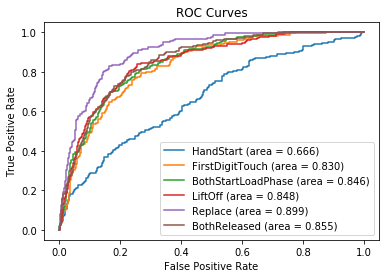

49069 49069
Train subject 10, class HandStart
Train on 1944 samples, validate on 486 samples
Epoch 1/100
1944/1944 [==============================] - 4s 2ms/step - loss: 0.6935 - acc: 0.5018 - val_loss: 0.6937 - val_acc: 0.4835
Epoch 2/100
1944/1944 [==============================] - 3s 2ms/step - loss: 0.6943 - acc: 0.4871 - val_loss: 0.6935 - val_acc: 0.4835
Epoch 3/100
1944/1944 [==============================] - 3s 2ms/step - loss: 0.6935 - acc: 0.5057 - val_loss: 0.6931 - val_acc: 0.4815
Epoch 4/100
1944/1944 [==============================] - 3s 2ms/step - loss: 0.6914 - acc: 0.5190 - val_loss: 0.6928 - val_acc: 0.4856
Epoch 5/100
1944/1944 [==============================] - 3s 2ms/step - loss: 0.6912 - acc: 0.5165 - val_loss: 0.6925 - val_acc: 0.4856
Epoch 6/100
1944/1944 [==============================] - 3s 2ms/step - loss: 0.6921 - acc: 0.5098 - val_loss: 0.6921 - val_acc: 0.4918
Epoch 7/100
1944/1944 [==============================] - 3s 2ms/step - loss: 0.6914 - acc: 0.5170

1944/1944 [==============================] - 3s 2ms/step - loss: 0.4781 - acc: 0.7906 - val_loss: 0.5026 - val_acc: 0.7840
Epoch 61/100
1944/1944 [==============================] - 3s 2ms/step - loss: 0.4772 - acc: 0.7948 - val_loss: 0.4989 - val_acc: 0.7901
Epoch 62/100
1944/1944 [==============================] - 3s 2ms/step - loss: 0.4664 - acc: 0.8040 - val_loss: 0.4973 - val_acc: 0.7922
Epoch 63/100
1944/1944 [==============================] - 3s 2ms/step - loss: 0.4668 - acc: 0.8020 - val_loss: 0.4936 - val_acc: 0.7942
Epoch 64/100
1944/1944 [==============================] - 3s 2ms/step - loss: 0.4658 - acc: 0.7994 - val_loss: 0.4941 - val_acc: 0.7922
Epoch 65/100
1944/1944 [==============================] - 3s 2ms/step - loss: 0.4650 - acc: 0.8066 - val_loss: 0.4875 - val_acc: 0.8004
Epoch 66/100
1944/1944 [==============================] - 3s 2ms/step - loss: 0.4625 - acc: 0.7917 - val_loss: 0.4843 - val_acc: 0.7963
Epoch 67/100
1944/1944 [==============================] - 3s 

1944/1944 [==============================] - 3s 2ms/step - loss: 0.3939 - acc: 0.8426 - val_loss: 0.3932 - val_acc: 0.8580
Epoch 21/100
1944/1944 [==============================] - 3s 2ms/step - loss: 0.3928 - acc: 0.8374 - val_loss: 0.3919 - val_acc: 0.8621
Epoch 22/100
1944/1944 [==============================] - 3s 2ms/step - loss: 0.3894 - acc: 0.8400 - val_loss: 0.3949 - val_acc: 0.8477
Epoch 23/100
1944/1944 [==============================] - 3s 2ms/step - loss: 0.3955 - acc: 0.8333 - val_loss: 0.3884 - val_acc: 0.8580
Epoch 24/100
1944/1944 [==============================] - 3s 2ms/step - loss: 0.3857 - acc: 0.8385 - val_loss: 0.3892 - val_acc: 0.8580
Epoch 25/100
1944/1944 [==============================] - 3s 2ms/step - loss: 0.3865 - acc: 0.8436 - val_loss: 0.3892 - val_acc: 0.8560
Epoch 26/100
1944/1944 [==============================] - 3s 2ms/step - loss: 0.3838 - acc: 0.8380 - val_loss: 0.3878 - val_acc: 0.8580
Epoch 27/100
1944/1944 [==============================] - 3s 

1944/1944 [==============================] - 3s 2ms/step - loss: 0.3232 - acc: 0.8683 - val_loss: 0.3307 - val_acc: 0.8827
Epoch 81/100
1944/1944 [==============================] - 3s 2ms/step - loss: 0.3236 - acc: 0.8678 - val_loss: 0.3299 - val_acc: 0.8848
Epoch 82/100
1944/1944 [==============================] - 3s 2ms/step - loss: 0.3291 - acc: 0.8699 - val_loss: 0.3280 - val_acc: 0.8930
Epoch 83/100
1944/1944 [==============================] - 3s 2ms/step - loss: 0.3167 - acc: 0.8765 - val_loss: 0.3271 - val_acc: 0.8889
Epoch 84/100
1944/1944 [==============================] - 3s 2ms/step - loss: 0.3211 - acc: 0.8699 - val_loss: 0.3275 - val_acc: 0.8848
Epoch 85/100
1944/1944 [==============================] - 3s 2ms/step - loss: 0.3137 - acc: 0.8786 - val_loss: 0.3259 - val_acc: 0.8827
Epoch 86/100
1944/1944 [==============================] - 3s 2ms/step - loss: 0.3105 - acc: 0.8765 - val_loss: 0.3250 - val_acc: 0.8827
Epoch 87/100
1944/1944 [==============================] - 3s 

1944/1944 [==============================] - 3s 2ms/step - loss: 0.3848 - acc: 0.8447 - val_loss: 0.4155 - val_acc: 0.8169
Epoch 40/100
1944/1944 [==============================] - 3s 2ms/step - loss: 0.3745 - acc: 0.8477 - val_loss: 0.4098 - val_acc: 0.8210
Epoch 41/100
1944/1944 [==============================] - 3s 2ms/step - loss: 0.3730 - acc: 0.8431 - val_loss: 0.4044 - val_acc: 0.8189
Epoch 42/100
1944/1944 [==============================] - 3s 2ms/step - loss: 0.3663 - acc: 0.8534 - val_loss: 0.4027 - val_acc: 0.8292
Epoch 43/100
1944/1944 [==============================] - 3s 2ms/step - loss: 0.3666 - acc: 0.8513 - val_loss: 0.3934 - val_acc: 0.8272
Epoch 44/100
1944/1944 [==============================] - 3s 2ms/step - loss: 0.3597 - acc: 0.8570 - val_loss: 0.3902 - val_acc: 0.8374
Epoch 45/100
1944/1944 [==============================] - 3s 2ms/step - loss: 0.3476 - acc: 0.8606 - val_loss: 0.3836 - val_acc: 0.8374
Epoch 46/100
1944/1944 [==============================] - 3s 

1944/1944 [==============================] - 3s 2ms/step - loss: 0.2465 - acc: 0.9043 - val_loss: 0.2797 - val_acc: 0.9033
Epoch 100/100
1944/1944 [==============================] - 3s 2ms/step - loss: 0.2482 - acc: 0.9017 - val_loss: 0.2859 - val_acc: 0.8971
Train on 1944 samples, validate on 486 samples
Epoch 1/100
1944/1944 [==============================] - 3s 2ms/step - loss: 0.2829 - acc: 0.8915 - val_loss: 0.2719 - val_acc: 0.9012
Epoch 2/100
1944/1944 [==============================] - 3s 2ms/step - loss: 0.2766 - acc: 0.8920 - val_loss: 0.2816 - val_acc: 0.9053
Epoch 3/100
1944/1944 [==============================] - 3s 2ms/step - loss: 0.2750 - acc: 0.8909 - val_loss: 0.2667 - val_acc: 0.9033
Epoch 4/100
1944/1944 [==============================] - 3s 2ms/step - loss: 0.2623 - acc: 0.8971 - val_loss: 0.2959 - val_acc: 0.8992
Epoch 5/100
1944/1944 [==============================] - 3s 2ms/step - loss: 0.2604 - acc: 0.8976 - val_loss: 0.2878 - val_acc: 0.9012
Epoch 6/100
1944/1

1944/1944 [==============================] - 3s 2ms/step - loss: 0.2002 - acc: 0.9254 - val_loss: 0.2826 - val_acc: 0.8971
Epoch 60/100
1944/1944 [==============================] - 3s 2ms/step - loss: 0.1920 - acc: 0.9342 - val_loss: 0.2700 - val_acc: 0.9095
Epoch 61/100
1944/1944 [==============================] - 3s 2ms/step - loss: 0.1989 - acc: 0.9316 - val_loss: 0.2667 - val_acc: 0.9115
Epoch 62/100
1944/1944 [==============================] - 3s 2ms/step - loss: 0.1996 - acc: 0.9306 - val_loss: 0.2445 - val_acc: 0.9115
Epoch 63/100
1944/1944 [==============================] - 3s 2ms/step - loss: 0.1903 - acc: 0.9321 - val_loss: 0.2632 - val_acc: 0.9115
Epoch 64/100
1944/1944 [==============================] - 3s 2ms/step - loss: 0.1976 - acc: 0.9264 - val_loss: 0.2359 - val_acc: 0.9136
Epoch 65/100
1944/1944 [==============================] - 3s 2ms/step - loss: 0.1984 - acc: 0.9290 - val_loss: 0.2556 - val_acc: 0.9115
Epoch 66/100
1944/1944 [==============================] - 3s 

1944/1944 [==============================] - 3s 2ms/step - loss: 0.6691 - acc: 0.6332 - val_loss: 0.6651 - val_acc: 0.6831
Epoch 19/100
1944/1944 [==============================] - 3s 2ms/step - loss: 0.6679 - acc: 0.6317 - val_loss: 0.6620 - val_acc: 0.7016
Epoch 20/100
1944/1944 [==============================] - 3s 2ms/step - loss: 0.6625 - acc: 0.6435 - val_loss: 0.6607 - val_acc: 0.6687
Epoch 21/100
1944/1944 [==============================] - 3s 2ms/step - loss: 0.6597 - acc: 0.6497 - val_loss: 0.6553 - val_acc: 0.7078
Epoch 22/100
1944/1944 [==============================] - 3s 2ms/step - loss: 0.6572 - acc: 0.6476 - val_loss: 0.6519 - val_acc: 0.7119
Epoch 23/100
1944/1944 [==============================] - 3s 2ms/step - loss: 0.6537 - acc: 0.6759 - val_loss: 0.6508 - val_acc: 0.6811
Epoch 24/100
1944/1944 [==============================] - 3s 2ms/step - loss: 0.6476 - acc: 0.6785 - val_loss: 0.6455 - val_acc: 0.6872
Epoch 25/100
1944/1944 [==============================] - 3s 

1944/1944 [==============================] - 3s 2ms/step - loss: 0.3180 - acc: 0.8817 - val_loss: 0.3074 - val_acc: 0.8930
Epoch 79/100
1944/1944 [==============================] - 3s 2ms/step - loss: 0.3099 - acc: 0.8868 - val_loss: 0.3033 - val_acc: 0.8930
Epoch 80/100
1944/1944 [==============================] - 3s 2ms/step - loss: 0.3040 - acc: 0.8915 - val_loss: 0.3219 - val_acc: 0.8848
Epoch 81/100
1944/1944 [==============================] - 3s 2ms/step - loss: 0.3084 - acc: 0.8868 - val_loss: 0.3076 - val_acc: 0.8951
Epoch 82/100
1944/1944 [==============================] - 3s 2ms/step - loss: 0.3017 - acc: 0.8909 - val_loss: 0.2987 - val_acc: 0.8930
Epoch 83/100
1944/1944 [==============================] - 3s 2ms/step - loss: 0.3058 - acc: 0.8858 - val_loss: 0.3024 - val_acc: 0.8971
Epoch 84/100
1944/1944 [==============================] - 3s 2ms/step - loss: 0.3003 - acc: 0.8843 - val_loss: 0.3070 - val_acc: 0.8930
Epoch 85/100
1944/1944 [==============================] - 3s 

1944/1944 [==============================] - 3s 2ms/step - loss: 0.2441 - acc: 0.9100 - val_loss: 0.2325 - val_acc: 0.9259
Epoch 39/100
1944/1944 [==============================] - 3s 2ms/step - loss: 0.2520 - acc: 0.9012 - val_loss: 0.2302 - val_acc: 0.9259
Epoch 40/100
1944/1944 [==============================] - 3s 2ms/step - loss: 0.2497 - acc: 0.8992 - val_loss: 0.2373 - val_acc: 0.9218
Epoch 41/100
1944/1944 [==============================] - 3s 2ms/step - loss: 0.2365 - acc: 0.9059 - val_loss: 0.2303 - val_acc: 0.9259
Epoch 42/100
1944/1944 [==============================] - 3s 2ms/step - loss: 0.2508 - acc: 0.9017 - val_loss: 0.2341 - val_acc: 0.9259
Epoch 43/100
1944/1944 [==============================] - 3s 2ms/step - loss: 0.2362 - acc: 0.9064 - val_loss: 0.2215 - val_acc: 0.9280
Epoch 44/100
1944/1944 [==============================] - 3s 2ms/step - loss: 0.2343 - acc: 0.9120 - val_loss: 0.2282 - val_acc: 0.9280
Epoch 45/100
1944/1944 [==============================] - 3s 

1944/1944 [==============================] - 3s 2ms/step - loss: 0.1821 - acc: 0.9372 - val_loss: 0.2161 - val_acc: 0.9362
Epoch 99/100
1944/1944 [==============================] - 3s 2ms/step - loss: 0.1834 - acc: 0.9367 - val_loss: 0.2118 - val_acc: 0.9383
Epoch 100/100
1944/1944 [==============================] - 3s 2ms/step - loss: 0.1763 - acc: 0.9342 - val_loss: 0.2083 - val_acc: 0.9342
Test subject 10, class BothStartLoadPhase
Train subject 10, class LiftOff
Train on 1944 samples, validate on 486 samples
Epoch 1/100
1944/1944 [==============================] - 4s 2ms/step - loss: 0.6954 - acc: 0.4758 - val_loss: 0.6927 - val_acc: 0.5247
Epoch 2/100
1944/1944 [==============================] - 3s 2ms/step - loss: 0.6954 - acc: 0.4959 - val_loss: 0.6915 - val_acc: 0.5185
Epoch 3/100
1944/1944 [==============================] - 3s 2ms/step - loss: 0.6934 - acc: 0.5159 - val_loss: 0.6903 - val_acc: 0.5700
Epoch 4/100
1944/1944 [==============================] - 3s 2ms/step - loss: 0

1944/1944 [==============================] - 3s 2ms/step - loss: 0.3172 - acc: 0.8740 - val_loss: 0.3737 - val_acc: 0.8848
Epoch 58/100
1944/1944 [==============================] - 3s 2ms/step - loss: 0.3102 - acc: 0.8755 - val_loss: 0.3854 - val_acc: 0.8848
Epoch 59/100
1944/1944 [==============================] - 3s 2ms/step - loss: 0.3097 - acc: 0.8740 - val_loss: 0.4007 - val_acc: 0.8724
Epoch 60/100
1944/1944 [==============================] - 3s 2ms/step - loss: 0.3049 - acc: 0.8796 - val_loss: 0.3820 - val_acc: 0.8848
Epoch 61/100
1944/1944 [==============================] - 3s 2ms/step - loss: 0.3075 - acc: 0.8765 - val_loss: 0.3602 - val_acc: 0.8889
Epoch 62/100
1944/1944 [==============================] - 3s 2ms/step - loss: 0.2879 - acc: 0.8873 - val_loss: 0.3822 - val_acc: 0.8909
Epoch 63/100
1944/1944 [==============================] - 3s 2ms/step - loss: 0.2868 - acc: 0.8873 - val_loss: 0.3720 - val_acc: 0.8909
Epoch 64/100
1944/1944 [==============================] - 3s 

1944/1944 [==============================] - 3s 2ms/step - loss: 0.2346 - acc: 0.9090 - val_loss: 0.3170 - val_acc: 0.8971
Epoch 18/100
1944/1944 [==============================] - 3s 2ms/step - loss: 0.2335 - acc: 0.9131 - val_loss: 0.2873 - val_acc: 0.9012
Epoch 19/100
1944/1944 [==============================] - 3s 2ms/step - loss: 0.2322 - acc: 0.9105 - val_loss: 0.3271 - val_acc: 0.8951
Epoch 20/100
1944/1944 [==============================] - 3s 2ms/step - loss: 0.2288 - acc: 0.9162 - val_loss: 0.3125 - val_acc: 0.8992
Epoch 21/100
1944/1944 [==============================] - 3s 2ms/step - loss: 0.2334 - acc: 0.9110 - val_loss: 0.3371 - val_acc: 0.8889
Epoch 22/100
1944/1944 [==============================] - 3s 2ms/step - loss: 0.2233 - acc: 0.9192 - val_loss: 0.3124 - val_acc: 0.8951
Epoch 23/100
1944/1944 [==============================] - 3s 2ms/step - loss: 0.2301 - acc: 0.9136 - val_loss: 0.2839 - val_acc: 0.8992
Epoch 24/100
1944/1944 [==============================] - 3s 

1944/1944 [==============================] - 3s 2ms/step - loss: 0.1845 - acc: 0.9290 - val_loss: 0.2898 - val_acc: 0.9012
Epoch 78/100
1944/1944 [==============================] - 3s 2ms/step - loss: 0.1742 - acc: 0.9331 - val_loss: 0.2902 - val_acc: 0.9012
Epoch 79/100
1944/1944 [==============================] - 3s 2ms/step - loss: 0.1765 - acc: 0.9331 - val_loss: 0.2876 - val_acc: 0.9012
Epoch 80/100
1944/1944 [==============================] - 3s 2ms/step - loss: 0.1751 - acc: 0.9362 - val_loss: 0.3014 - val_acc: 0.9053
Epoch 81/100
1944/1944 [==============================] - 3s 2ms/step - loss: 0.1756 - acc: 0.9331 - val_loss: 0.2677 - val_acc: 0.9095
Epoch 82/100
1944/1944 [==============================] - 3s 2ms/step - loss: 0.1764 - acc: 0.9367 - val_loss: 0.2783 - val_acc: 0.9033
Epoch 83/100
1944/1944 [==============================] - 3s 2ms/step - loss: 0.1703 - acc: 0.9342 - val_loss: 0.2752 - val_acc: 0.9033
Epoch 84/100
1944/1944 [==============================] - 3s 

1944/1944 [==============================] - 3s 2ms/step - loss: 0.4702 - acc: 0.7953 - val_loss: 0.4935 - val_acc: 0.7942
Epoch 37/100
1944/1944 [==============================] - 3s 2ms/step - loss: 0.4631 - acc: 0.7999 - val_loss: 0.4897 - val_acc: 0.8045
Epoch 38/100
1944/1944 [==============================] - 3s 2ms/step - loss: 0.4559 - acc: 0.8014 - val_loss: 0.4744 - val_acc: 0.7942
Epoch 39/100
1944/1944 [==============================] - 3s 2ms/step - loss: 0.4466 - acc: 0.8148 - val_loss: 0.4668 - val_acc: 0.7963
Epoch 40/100
1944/1944 [==============================] - 3s 2ms/step - loss: 0.4449 - acc: 0.8092 - val_loss: 0.4613 - val_acc: 0.8004
Epoch 41/100
1944/1944 [==============================] - 3s 2ms/step - loss: 0.4340 - acc: 0.8179 - val_loss: 0.4545 - val_acc: 0.8086
Epoch 42/100
1944/1944 [==============================] - 3s 2ms/step - loss: 0.4258 - acc: 0.8225 - val_loss: 0.4502 - val_acc: 0.8128
Epoch 43/100
1944/1944 [==============================] - 3s 

1944/1944 [==============================] - 3s 2ms/step - loss: 0.2500 - acc: 0.9043 - val_loss: 0.2893 - val_acc: 0.9033
Epoch 97/100
1944/1944 [==============================] - 3s 2ms/step - loss: 0.2548 - acc: 0.8997 - val_loss: 0.2836 - val_acc: 0.9053
Epoch 98/100
1944/1944 [==============================] - 3s 2ms/step - loss: 0.2523 - acc: 0.9028 - val_loss: 0.2885 - val_acc: 0.9033
Epoch 99/100
1944/1944 [==============================] - 3s 2ms/step - loss: 0.2482 - acc: 0.9064 - val_loss: 0.2834 - val_acc: 0.9115
Epoch 100/100
1944/1944 [==============================] - 3s 2ms/step - loss: 0.2396 - acc: 0.9090 - val_loss: 0.2801 - val_acc: 0.9053
Train on 1944 samples, validate on 486 samples
Epoch 1/100
1944/1944 [==============================] - 3s 2ms/step - loss: 0.3137 - acc: 0.8765 - val_loss: 0.3181 - val_acc: 0.8621
Epoch 2/100
1944/1944 [==============================] - 3s 2ms/step - loss: 0.3129 - acc: 0.8801 - val_loss: 0.3324 - val_acc: 0.8951
Epoch 3/100
194

1944/1944 [==============================] - 3s 2ms/step - loss: 0.2236 - acc: 0.9136 - val_loss: 0.2660 - val_acc: 0.9074
Epoch 57/100
1944/1944 [==============================] - 3s 2ms/step - loss: 0.2332 - acc: 0.9105 - val_loss: 0.2740 - val_acc: 0.9033
Epoch 58/100
1944/1944 [==============================] - 3s 2ms/step - loss: 0.2296 - acc: 0.9146 - val_loss: 0.2722 - val_acc: 0.9012
Epoch 59/100
1944/1944 [==============================] - 3s 2ms/step - loss: 0.2194 - acc: 0.9151 - val_loss: 0.2699 - val_acc: 0.9012
Epoch 60/100
1944/1944 [==============================] - 3s 2ms/step - loss: 0.2281 - acc: 0.9105 - val_loss: 0.2790 - val_acc: 0.9053
Epoch 61/100
1944/1944 [==============================] - 3s 2ms/step - loss: 0.2208 - acc: 0.9131 - val_loss: 0.2622 - val_acc: 0.9074
Epoch 62/100
1944/1944 [==============================] - 3s 2ms/step - loss: 0.2179 - acc: 0.9177 - val_loss: 0.2812 - val_acc: 0.9074
Epoch 63/100
1944/1944 [==============================] - 3s 

1944/1944 [==============================] - 3s 2ms/step - loss: 0.6381 - acc: 0.7140 - val_loss: 0.6428 - val_acc: 0.7202
Epoch 16/100
1944/1944 [==============================] - 3s 2ms/step - loss: 0.6282 - acc: 0.7305 - val_loss: 0.6349 - val_acc: 0.7469
Epoch 17/100
1944/1944 [==============================] - 3s 2ms/step - loss: 0.6222 - acc: 0.7279 - val_loss: 0.6268 - val_acc: 0.7490
Epoch 18/100
1944/1944 [==============================] - 3s 2ms/step - loss: 0.6124 - acc: 0.7341 - val_loss: 0.6177 - val_acc: 0.7428
Epoch 19/100
1944/1944 [==============================] - 3s 2ms/step - loss: 0.6017 - acc: 0.7289 - val_loss: 0.6122 - val_acc: 0.7325
Epoch 20/100
1944/1944 [==============================] - 3s 2ms/step - loss: 0.5865 - acc: 0.7546 - val_loss: 0.5999 - val_acc: 0.7613
Epoch 21/100
1944/1944 [==============================] - 3s 2ms/step - loss: 0.5710 - acc: 0.7623 - val_loss: 0.5916 - val_acc: 0.7428
Epoch 22/100
1944/1944 [==============================] - 3s 

1944/1944 [==============================] - 3s 2ms/step - loss: 0.2851 - acc: 0.8801 - val_loss: 0.3083 - val_acc: 0.8786
Epoch 76/100
1944/1944 [==============================] - 3s 2ms/step - loss: 0.2895 - acc: 0.8801 - val_loss: 0.3065 - val_acc: 0.8827
Epoch 77/100
1944/1944 [==============================] - 3s 2ms/step - loss: 0.2901 - acc: 0.8904 - val_loss: 0.3050 - val_acc: 0.8827
Epoch 78/100
1944/1944 [==============================] - 3s 2ms/step - loss: 0.2891 - acc: 0.8884 - val_loss: 0.3044 - val_acc: 0.8827
Epoch 79/100
1944/1944 [==============================] - 3s 2ms/step - loss: 0.2723 - acc: 0.8915 - val_loss: 0.3019 - val_acc: 0.8827
Epoch 80/100
1944/1944 [==============================] - 3s 2ms/step - loss: 0.2813 - acc: 0.8873 - val_loss: 0.3012 - val_acc: 0.8848
Epoch 81/100
1944/1944 [==============================] - 3s 2ms/step - loss: 0.2786 - acc: 0.8894 - val_loss: 0.2986 - val_acc: 0.8827
Epoch 82/100
1944/1944 [==============================] - 3s 

1944/1944 [==============================] - 3s 2ms/step - loss: 0.2428 - acc: 0.9115 - val_loss: 0.2573 - val_acc: 0.9136
Epoch 36/100
1944/1944 [==============================] - 3s 2ms/step - loss: 0.2317 - acc: 0.9126 - val_loss: 0.2552 - val_acc: 0.9095
Epoch 37/100
1944/1944 [==============================] - 3s 2ms/step - loss: 0.2432 - acc: 0.9126 - val_loss: 0.2575 - val_acc: 0.9115
Epoch 38/100
1944/1944 [==============================] - 3s 2ms/step - loss: 0.2347 - acc: 0.9177 - val_loss: 0.2553 - val_acc: 0.9115
Epoch 39/100
1944/1944 [==============================] - 3s 2ms/step - loss: 0.2317 - acc: 0.9162 - val_loss: 0.2576 - val_acc: 0.9074
Epoch 40/100
1944/1944 [==============================] - 3s 2ms/step - loss: 0.2334 - acc: 0.9167 - val_loss: 0.2577 - val_acc: 0.9074
Epoch 41/100
1944/1944 [==============================] - 3s 2ms/step - loss: 0.2391 - acc: 0.9177 - val_loss: 0.2586 - val_acc: 0.9074
Epoch 42/100
1944/1944 [==============================] - 3s 

1944/1944 [==============================] - 3s 2ms/step - loss: 0.1881 - acc: 0.9326 - val_loss: 0.2408 - val_acc: 0.9095
Epoch 96/100
1944/1944 [==============================] - 3s 2ms/step - loss: 0.1853 - acc: 0.9378 - val_loss: 0.2427 - val_acc: 0.9115
Epoch 97/100
1944/1944 [==============================] - 3s 2ms/step - loss: 0.1815 - acc: 0.9347 - val_loss: 0.2436 - val_acc: 0.9115
Epoch 98/100
1944/1944 [==============================] - 3s 2ms/step - loss: 0.1900 - acc: 0.9336 - val_loss: 0.2384 - val_acc: 0.9074
Epoch 99/100
1944/1944 [==============================] - 3s 2ms/step - loss: 0.1886 - acc: 0.9321 - val_loss: 0.2418 - val_acc: 0.9053
Epoch 100/100
1944/1944 [==============================] - 3s 2ms/step - loss: 0.1849 - acc: 0.9403 - val_loss: 0.2541 - val_acc: 0.9095
Test subject 10, class BothReleased
HandStart AUC score = 0.861
FirstDigitTouch AUC score = 0.941
BothStartLoadPhase AUC score = 0.894
LiftOff AUC score = 0.919
Replace AUC score = 0.887
BothRelea

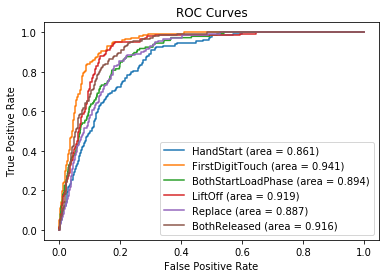

50195 50195
Train subject 11, class HandStart
Train on 1956 samples, validate on 489 samples
Epoch 1/100
1956/1956 [==============================] - 4s 2ms/step - loss: 0.6955 - acc: 0.4957 - val_loss: 0.6934 - val_acc: 0.5112
Epoch 2/100
1956/1956 [==============================] - 3s 2ms/step - loss: 0.6937 - acc: 0.5051 - val_loss: 0.6927 - val_acc: 0.5297
Epoch 3/100
1956/1956 [==============================] - 3s 2ms/step - loss: 0.6941 - acc: 0.5072 - val_loss: 0.6920 - val_acc: 0.5542
Epoch 4/100
1956/1956 [==============================] - 3s 2ms/step - loss: 0.6927 - acc: 0.5235 - val_loss: 0.6914 - val_acc: 0.5276
Epoch 5/100
1956/1956 [==============================] - 3s 2ms/step - loss: 0.6902 - acc: 0.5194 - val_loss: 0.6908 - val_acc: 0.5378
Epoch 6/100
1956/1956 [==============================] - 3s 2ms/step - loss: 0.6903 - acc: 0.5373 - val_loss: 0.6902 - val_acc: 0.5746
Epoch 7/100
1956/1956 [==============================] - 3s 2ms/step - loss: 0.6900 - acc: 0.5481

1956/1956 [==============================] - 3s 2ms/step - loss: 0.5957 - acc: 0.6856 - val_loss: 0.6175 - val_acc: 0.6442
Epoch 61/100
1956/1956 [==============================] - 3s 2ms/step - loss: 0.5822 - acc: 0.7050 - val_loss: 0.6117 - val_acc: 0.6524
Epoch 62/100
1956/1956 [==============================] - 3s 2ms/step - loss: 0.5750 - acc: 0.7096 - val_loss: 0.6202 - val_acc: 0.6646
Epoch 63/100
1956/1956 [==============================] - 3s 2ms/step - loss: 0.5796 - acc: 0.7081 - val_loss: 0.6128 - val_acc: 0.6544
Epoch 64/100
1956/1956 [==============================] - 3s 2ms/step - loss: 0.5744 - acc: 0.7096 - val_loss: 0.6154 - val_acc: 0.6708
Epoch 65/100
1956/1956 [==============================] - 3s 2ms/step - loss: 0.5678 - acc: 0.7122 - val_loss: 0.5972 - val_acc: 0.6708
Epoch 66/100
1956/1956 [==============================] - 3s 2ms/step - loss: 0.5683 - acc: 0.7188 - val_loss: 0.5940 - val_acc: 0.6728
Epoch 67/100
1956/1956 [==============================] - 3s 

1956/1956 [==============================] - 3s 2ms/step - loss: 0.4309 - acc: 0.8206 - val_loss: 0.4686 - val_acc: 0.7935
Epoch 21/100
1956/1956 [==============================] - 3s 2ms/step - loss: 0.4327 - acc: 0.8113 - val_loss: 0.4606 - val_acc: 0.7996
Epoch 22/100
1956/1956 [==============================] - 3s 2ms/step - loss: 0.4211 - acc: 0.8190 - val_loss: 0.4044 - val_acc: 0.8507
Epoch 23/100
1956/1956 [==============================] - 3s 2ms/step - loss: 0.4256 - acc: 0.8231 - val_loss: 0.4052 - val_acc: 0.8282
Epoch 24/100
1956/1956 [==============================] - 3s 2ms/step - loss: 0.4247 - acc: 0.8149 - val_loss: 0.4435 - val_acc: 0.8098
Epoch 25/100
1956/1956 [==============================] - 3s 2ms/step - loss: 0.4162 - acc: 0.8267 - val_loss: 0.4446 - val_acc: 0.8119
Epoch 26/100
1956/1956 [==============================] - 3s 2ms/step - loss: 0.4179 - acc: 0.8226 - val_loss: 0.4575 - val_acc: 0.7996
Epoch 27/100
1956/1956 [==============================] - 3s 

1956/1956 [==============================] - 3s 2ms/step - loss: 0.2855 - acc: 0.8819 - val_loss: 0.3382 - val_acc: 0.8630
Epoch 81/100
1956/1956 [==============================] - 3s 2ms/step - loss: 0.2885 - acc: 0.8885 - val_loss: 0.3000 - val_acc: 0.8957
Epoch 82/100
1956/1956 [==============================] - 3s 2ms/step - loss: 0.2946 - acc: 0.8824 - val_loss: 0.3662 - val_acc: 0.8446
Epoch 83/100
1956/1956 [==============================] - 3s 2ms/step - loss: 0.2904 - acc: 0.8829 - val_loss: 0.3539 - val_acc: 0.8569
Epoch 84/100
1956/1956 [==============================] - 3s 2ms/step - loss: 0.2960 - acc: 0.8834 - val_loss: 0.3288 - val_acc: 0.8671
Epoch 85/100
1956/1956 [==============================] - 3s 2ms/step - loss: 0.2852 - acc: 0.8916 - val_loss: 0.3371 - val_acc: 0.8630
Epoch 86/100
1956/1956 [==============================] - 3s 2ms/step - loss: 0.2919 - acc: 0.8783 - val_loss: 0.3409 - val_acc: 0.8609
Epoch 87/100
1956/1956 [==============================] - 3s 

1956/1956 [==============================] - 3s 2ms/step - loss: 0.5982 - acc: 0.6887 - val_loss: 0.5972 - val_acc: 0.6789
Epoch 40/100
1956/1956 [==============================] - 3s 2ms/step - loss: 0.5907 - acc: 0.6922 - val_loss: 0.5964 - val_acc: 0.6789
Epoch 41/100
1956/1956 [==============================] - 3s 2ms/step - loss: 0.5866 - acc: 0.6938 - val_loss: 0.6173 - val_acc: 0.6748
Epoch 42/100
1956/1956 [==============================] - 3s 2ms/step - loss: 0.5895 - acc: 0.6887 - val_loss: 0.5914 - val_acc: 0.6851
Epoch 43/100
1956/1956 [==============================] - 3s 2ms/step - loss: 0.5768 - acc: 0.7086 - val_loss: 0.5842 - val_acc: 0.6871
Epoch 44/100
1956/1956 [==============================] - 3s 2ms/step - loss: 0.5794 - acc: 0.6968 - val_loss: 0.5819 - val_acc: 0.6953
Epoch 45/100
1956/1956 [==============================] - 3s 2ms/step - loss: 0.5697 - acc: 0.7127 - val_loss: 0.6156 - val_acc: 0.6892
Epoch 46/100
1956/1956 [==============================] - 3s 

1956/1956 [==============================] - 3s 2ms/step - loss: 0.3060 - acc: 0.8814 - val_loss: 0.3524 - val_acc: 0.8814
Epoch 100/100
1956/1956 [==============================] - 3s 2ms/step - loss: 0.2986 - acc: 0.8839 - val_loss: 0.3615 - val_acc: 0.8834
Train on 1956 samples, validate on 489 samples
Epoch 1/100
1956/1956 [==============================] - 3s 2ms/step - loss: 0.3656 - acc: 0.8497 - val_loss: 0.2885 - val_acc: 0.8834
Epoch 2/100
1956/1956 [==============================] - 3s 2ms/step - loss: 0.3576 - acc: 0.8502 - val_loss: 0.2877 - val_acc: 0.8814
Epoch 3/100
1956/1956 [==============================] - 3s 2ms/step - loss: 0.3375 - acc: 0.8604 - val_loss: 0.2790 - val_acc: 0.8834
Epoch 4/100
1956/1956 [==============================] - 3s 2ms/step - loss: 0.3429 - acc: 0.8594 - val_loss: 0.2740 - val_acc: 0.8814
Epoch 5/100
1956/1956 [==============================] - 3s 2ms/step - loss: 0.3287 - acc: 0.8635 - val_loss: 0.2703 - val_acc: 0.8834
Epoch 6/100
1956/1

1956/1956 [==============================] - 3s 2ms/step - loss: 0.2147 - acc: 0.9223 - val_loss: 0.1965 - val_acc: 0.9223
Epoch 60/100
1956/1956 [==============================] - 3s 2ms/step - loss: 0.2167 - acc: 0.9238 - val_loss: 0.2279 - val_acc: 0.9121
Epoch 61/100
1956/1956 [==============================] - 3s 2ms/step - loss: 0.2245 - acc: 0.9208 - val_loss: 0.2124 - val_acc: 0.9243
Epoch 62/100
1956/1956 [==============================] - 3s 2ms/step - loss: 0.2196 - acc: 0.9177 - val_loss: 0.2002 - val_acc: 0.9264
Epoch 63/100
1956/1956 [==============================] - 3s 2ms/step - loss: 0.2136 - acc: 0.9192 - val_loss: 0.2067 - val_acc: 0.9243
Epoch 64/100
1956/1956 [==============================] - 3s 2ms/step - loss: 0.2176 - acc: 0.9233 - val_loss: 0.2033 - val_acc: 0.9264
Epoch 65/100
1956/1956 [==============================] - 3s 2ms/step - loss: 0.2149 - acc: 0.9248 - val_loss: 0.1938 - val_acc: 0.9243
Epoch 66/100
1956/1956 [==============================] - 3s 

1956/1956 [==============================] - 3s 2ms/step - loss: 0.6643 - acc: 0.6426 - val_loss: 0.6665 - val_acc: 0.5930
Epoch 19/100
1956/1956 [==============================] - 3s 2ms/step - loss: 0.6620 - acc: 0.6600 - val_loss: 0.6638 - val_acc: 0.5930
Epoch 20/100
1956/1956 [==============================] - 3s 2ms/step - loss: 0.6591 - acc: 0.6544 - val_loss: 0.6603 - val_acc: 0.6217
Epoch 21/100
1956/1956 [==============================] - 3s 2ms/step - loss: 0.6574 - acc: 0.6508 - val_loss: 0.6582 - val_acc: 0.6012
Epoch 22/100
1956/1956 [==============================] - 3s 2ms/step - loss: 0.6509 - acc: 0.6748 - val_loss: 0.6569 - val_acc: 0.5746
Epoch 23/100
1956/1956 [==============================] - 3s 2ms/step - loss: 0.6494 - acc: 0.6677 - val_loss: 0.6483 - val_acc: 0.7076
Epoch 24/100
1956/1956 [==============================] - 3s 2ms/step - loss: 0.6418 - acc: 0.6979 - val_loss: 0.6460 - val_acc: 0.6789
Epoch 25/100
1956/1956 [==============================] - 3s 

1956/1956 [==============================] - 3s 2ms/step - loss: 0.3261 - acc: 0.8671 - val_loss: 0.3741 - val_acc: 0.8303
Epoch 79/100
1956/1956 [==============================] - 3s 2ms/step - loss: 0.3290 - acc: 0.8635 - val_loss: 0.4116 - val_acc: 0.8262
Epoch 80/100
1956/1956 [==============================] - 3s 2ms/step - loss: 0.3290 - acc: 0.8661 - val_loss: 0.3748 - val_acc: 0.8282
Epoch 81/100
1956/1956 [==============================] - 3s 2ms/step - loss: 0.3292 - acc: 0.8620 - val_loss: 0.3982 - val_acc: 0.8344
Epoch 82/100
1956/1956 [==============================] - 3s 2ms/step - loss: 0.3242 - acc: 0.8671 - val_loss: 0.3667 - val_acc: 0.8507
Epoch 83/100
1956/1956 [==============================] - 3s 2ms/step - loss: 0.3053 - acc: 0.8763 - val_loss: 0.3618 - val_acc: 0.8344
Epoch 84/100
1956/1956 [==============================] - 3s 2ms/step - loss: 0.3139 - acc: 0.8712 - val_loss: 0.3731 - val_acc: 0.8487
Epoch 85/100
1956/1956 [==============================] - 3s 

1956/1956 [==============================] - 3s 2ms/step - loss: 0.2354 - acc: 0.9024 - val_loss: 0.2358 - val_acc: 0.9059
Epoch 39/100
1956/1956 [==============================] - 3s 2ms/step - loss: 0.2258 - acc: 0.9167 - val_loss: 0.2404 - val_acc: 0.9121
Epoch 40/100
1956/1956 [==============================] - 3s 2ms/step - loss: 0.2271 - acc: 0.9202 - val_loss: 0.2526 - val_acc: 0.9059
Epoch 41/100
1956/1956 [==============================] - 3s 2ms/step - loss: 0.2242 - acc: 0.9131 - val_loss: 0.2869 - val_acc: 0.9018
Epoch 42/100
1956/1956 [==============================] - 3s 2ms/step - loss: 0.2199 - acc: 0.9192 - val_loss: 0.2471 - val_acc: 0.9059
Epoch 43/100
1956/1956 [==============================] - 3s 2ms/step - loss: 0.2161 - acc: 0.9248 - val_loss: 0.2359 - val_acc: 0.9162
Epoch 44/100
1956/1956 [==============================] - 3s 2ms/step - loss: 0.2142 - acc: 0.9259 - val_loss: 0.2509 - val_acc: 0.9100
Epoch 45/100
1956/1956 [==============================] - 3s 

1956/1956 [==============================] - 3s 2ms/step - loss: 0.1569 - acc: 0.9479 - val_loss: 0.2102 - val_acc: 0.9366
Epoch 99/100
1956/1956 [==============================] - 3s 2ms/step - loss: 0.1655 - acc: 0.9438 - val_loss: 0.3059 - val_acc: 0.9039
Epoch 100/100
1956/1956 [==============================] - 3s 2ms/step - loss: 0.1565 - acc: 0.9453 - val_loss: 0.2048 - val_acc: 0.9448
Test subject 11, class BothStartLoadPhase
Train subject 11, class LiftOff
Train on 1955 samples, validate on 489 samples
Epoch 1/100
1955/1955 [==============================] - 5s 2ms/step - loss: 0.6955 - acc: 0.5059 - val_loss: 0.6921 - val_acc: 0.5174
Epoch 2/100
1955/1955 [==============================] - 3s 2ms/step - loss: 0.6936 - acc: 0.5023 - val_loss: 0.6913 - val_acc: 0.5501
Epoch 3/100
1955/1955 [==============================] - 3s 2ms/step - loss: 0.6924 - acc: 0.5376 - val_loss: 0.6906 - val_acc: 0.5521
Epoch 4/100
1955/1955 [==============================] - 3s 2ms/step - loss: 0

1955/1955 [==============================] - 3s 2ms/step - loss: 0.4861 - acc: 0.7857 - val_loss: 0.5101 - val_acc: 0.7730
Epoch 58/100
1955/1955 [==============================] - 3s 2ms/step - loss: 0.4722 - acc: 0.7887 - val_loss: 0.4975 - val_acc: 0.7894
Epoch 59/100
1955/1955 [==============================] - 3s 2ms/step - loss: 0.4739 - acc: 0.7841 - val_loss: 0.4891 - val_acc: 0.7975
Epoch 60/100
1955/1955 [==============================] - 3s 2ms/step - loss: 0.4604 - acc: 0.8046 - val_loss: 0.4809 - val_acc: 0.7873
Epoch 61/100
1955/1955 [==============================] - 3s 2ms/step - loss: 0.4615 - acc: 0.8036 - val_loss: 0.4752 - val_acc: 0.7853
Epoch 62/100
1955/1955 [==============================] - 3s 2ms/step - loss: 0.4474 - acc: 0.8020 - val_loss: 0.4769 - val_acc: 0.7832
Epoch 63/100
1955/1955 [==============================] - 3s 2ms/step - loss: 0.4407 - acc: 0.8128 - val_loss: 0.4712 - val_acc: 0.8016
Epoch 64/100
1955/1955 [==============================] - 3s 

1955/1955 [==============================] - 3s 2ms/step - loss: 0.2957 - acc: 0.8808 - val_loss: 0.2696 - val_acc: 0.8896
Epoch 18/100
1955/1955 [==============================] - 3s 2ms/step - loss: 0.2882 - acc: 0.8957 - val_loss: 0.2769 - val_acc: 0.8855
Epoch 19/100
1955/1955 [==============================] - 3s 2ms/step - loss: 0.2791 - acc: 0.8885 - val_loss: 0.2711 - val_acc: 0.8855
Epoch 20/100
1955/1955 [==============================] - 3s 2ms/step - loss: 0.2791 - acc: 0.8829 - val_loss: 0.2656 - val_acc: 0.8957
Epoch 21/100
1955/1955 [==============================] - 3s 2ms/step - loss: 0.2788 - acc: 0.8875 - val_loss: 0.3562 - val_acc: 0.8691
Epoch 22/100
1955/1955 [==============================] - 3s 2ms/step - loss: 0.2776 - acc: 0.8885 - val_loss: 0.2971 - val_acc: 0.8834
Epoch 23/100
1955/1955 [==============================] - 3s 2ms/step - loss: 0.2701 - acc: 0.8941 - val_loss: 0.2633 - val_acc: 0.8978
Epoch 24/100
1955/1955 [==============================] - 3s 

1955/1955 [==============================] - 3s 2ms/step - loss: 0.1853 - acc: 0.9340 - val_loss: 0.2642 - val_acc: 0.9039
Epoch 78/100
1955/1955 [==============================] - 3s 2ms/step - loss: 0.1854 - acc: 0.9345 - val_loss: 0.2651 - val_acc: 0.9039
Epoch 79/100
1955/1955 [==============================] - 3s 2ms/step - loss: 0.1872 - acc: 0.9366 - val_loss: 0.2847 - val_acc: 0.8937
Epoch 80/100
1955/1955 [==============================] - 3s 2ms/step - loss: 0.1825 - acc: 0.9263 - val_loss: 0.2644 - val_acc: 0.9039
Epoch 81/100
1955/1955 [==============================] - 3s 2ms/step - loss: 0.1787 - acc: 0.9330 - val_loss: 0.2195 - val_acc: 0.9202
Epoch 82/100
1955/1955 [==============================] - 3s 2ms/step - loss: 0.1823 - acc: 0.9315 - val_loss: 0.3168 - val_acc: 0.8834
Epoch 83/100
1955/1955 [==============================] - 3s 2ms/step - loss: 0.1708 - acc: 0.9381 - val_loss: 0.2465 - val_acc: 0.9121
Epoch 84/100
1955/1955 [==============================] - 3s 

1944/1944 [==============================] - 3s 2ms/step - loss: 0.5443 - acc: 0.7711 - val_loss: 0.5535 - val_acc: 0.7757
Epoch 37/100
1944/1944 [==============================] - 3s 2ms/step - loss: 0.5301 - acc: 0.7716 - val_loss: 0.5424 - val_acc: 0.7757
Epoch 38/100
1944/1944 [==============================] - 3s 2ms/step - loss: 0.5098 - acc: 0.7948 - val_loss: 0.5284 - val_acc: 0.7881
Epoch 39/100
1944/1944 [==============================] - 3s 2ms/step - loss: 0.5013 - acc: 0.7973 - val_loss: 0.5156 - val_acc: 0.7963
Epoch 40/100
1944/1944 [==============================] - 3s 2ms/step - loss: 0.4810 - acc: 0.8076 - val_loss: 0.5030 - val_acc: 0.7963
Epoch 41/100
1944/1944 [==============================] - 3s 2ms/step - loss: 0.4702 - acc: 0.8056 - val_loss: 0.4940 - val_acc: 0.7922
Epoch 42/100
1944/1944 [==============================] - 3s 2ms/step - loss: 0.4533 - acc: 0.8128 - val_loss: 0.4787 - val_acc: 0.7984
Epoch 43/100
1944/1944 [==============================] - 3s 

1944/1944 [==============================] - 3s 2ms/step - loss: 0.2389 - acc: 0.9038 - val_loss: 0.2727 - val_acc: 0.8848
Epoch 97/100
1944/1944 [==============================] - 3s 2ms/step - loss: 0.2220 - acc: 0.9156 - val_loss: 0.2712 - val_acc: 0.8889
Epoch 98/100
1944/1944 [==============================] - 3s 2ms/step - loss: 0.2327 - acc: 0.9146 - val_loss: 0.2828 - val_acc: 0.8827
Epoch 99/100
1944/1944 [==============================] - 3s 2ms/step - loss: 0.2277 - acc: 0.9074 - val_loss: 0.3057 - val_acc: 0.8745
Epoch 100/100
1944/1944 [==============================] - 3s 2ms/step - loss: 0.2320 - acc: 0.9110 - val_loss: 0.2973 - val_acc: 0.8765
Train on 1944 samples, validate on 486 samples
Epoch 1/100
1944/1944 [==============================] - 3s 2ms/step - loss: 0.2642 - acc: 0.8915 - val_loss: 0.2562 - val_acc: 0.9095
Epoch 2/100
1944/1944 [==============================] - 3s 2ms/step - loss: 0.2608 - acc: 0.8940 - val_loss: 0.2792 - val_acc: 0.8889
Epoch 3/100
194

1944/1944 [==============================] - 3s 2ms/step - loss: 0.1752 - acc: 0.9316 - val_loss: 0.2470 - val_acc: 0.9115
Epoch 57/100
1944/1944 [==============================] - 3s 2ms/step - loss: 0.1817 - acc: 0.9295 - val_loss: 0.2074 - val_acc: 0.9259
Epoch 58/100
1944/1944 [==============================] - 3s 2ms/step - loss: 0.1722 - acc: 0.9316 - val_loss: 0.2161 - val_acc: 0.9280
Epoch 59/100
1944/1944 [==============================] - 3s 2ms/step - loss: 0.1818 - acc: 0.9270 - val_loss: 0.2625 - val_acc: 0.9095
Epoch 60/100
1944/1944 [==============================] - 3s 2ms/step - loss: 0.1810 - acc: 0.9239 - val_loss: 0.2595 - val_acc: 0.9074
Epoch 61/100
1944/1944 [==============================] - 3s 2ms/step - loss: 0.1689 - acc: 0.9336 - val_loss: 0.2540 - val_acc: 0.9095
Epoch 62/100
1944/1944 [==============================] - 3s 2ms/step - loss: 0.1732 - acc: 0.9326 - val_loss: 0.2318 - val_acc: 0.9218
Epoch 63/100
1944/1944 [==============================] - 3s 

1942/1942 [==============================] - 3s 2ms/step - loss: 0.6665 - acc: 0.6184 - val_loss: 0.6621 - val_acc: 0.6914
Epoch 16/100
1942/1942 [==============================] - 3s 2ms/step - loss: 0.6620 - acc: 0.6401 - val_loss: 0.6590 - val_acc: 0.6728
Epoch 17/100
1942/1942 [==============================] - 3s 2ms/step - loss: 0.6598 - acc: 0.6452 - val_loss: 0.6562 - val_acc: 0.6955
Epoch 18/100
1942/1942 [==============================] - 3s 2ms/step - loss: 0.6552 - acc: 0.6550 - val_loss: 0.6527 - val_acc: 0.6955
Epoch 19/100
1942/1942 [==============================] - 3s 2ms/step - loss: 0.6470 - acc: 0.6637 - val_loss: 0.6493 - val_acc: 0.7037
Epoch 20/100
1942/1942 [==============================] - 3s 2ms/step - loss: 0.6479 - acc: 0.6504 - val_loss: 0.6452 - val_acc: 0.6831
Epoch 21/100
1942/1942 [==============================] - 3s 2ms/step - loss: 0.6418 - acc: 0.6684 - val_loss: 0.6412 - val_acc: 0.6852
Epoch 22/100
1942/1942 [==============================] - 3s 

1942/1942 [==============================] - 3s 2ms/step - loss: 0.2733 - acc: 0.8924 - val_loss: 0.3133 - val_acc: 0.8765
Epoch 76/100
1942/1942 [==============================] - 3s 2ms/step - loss: 0.2695 - acc: 0.8939 - val_loss: 0.2721 - val_acc: 0.9012
Epoch 77/100
1942/1942 [==============================] - 3s 2ms/step - loss: 0.2675 - acc: 0.8934 - val_loss: 0.2838 - val_acc: 0.8909
Epoch 78/100
1942/1942 [==============================] - 3s 2ms/step - loss: 0.2574 - acc: 0.9042 - val_loss: 0.2703 - val_acc: 0.8909
Epoch 79/100
1942/1942 [==============================] - 3s 2ms/step - loss: 0.2570 - acc: 0.9006 - val_loss: 0.2794 - val_acc: 0.8951
Epoch 80/100
1942/1942 [==============================] - 3s 2ms/step - loss: 0.2623 - acc: 0.8950 - val_loss: 0.2679 - val_acc: 0.8909
Epoch 81/100
1942/1942 [==============================] - 3s 2ms/step - loss: 0.2462 - acc: 0.9089 - val_loss: 0.2723 - val_acc: 0.8951
Epoch 82/100
1942/1942 [==============================] - 3s 

1942/1942 [==============================] - 3s 2ms/step - loss: 0.1702 - acc: 0.9387 - val_loss: 0.1891 - val_acc: 0.9321
Epoch 36/100
1942/1942 [==============================] - 3s 2ms/step - loss: 0.1666 - acc: 0.9398 - val_loss: 0.2001 - val_acc: 0.9280
Epoch 37/100
1942/1942 [==============================] - 3s 2ms/step - loss: 0.1606 - acc: 0.9459 - val_loss: 0.1946 - val_acc: 0.9280
Epoch 38/100
1942/1942 [==============================] - 3s 2ms/step - loss: 0.1639 - acc: 0.9444 - val_loss: 0.1867 - val_acc: 0.9321
Epoch 39/100
1942/1942 [==============================] - 3s 2ms/step - loss: 0.1594 - acc: 0.9459 - val_loss: 0.1845 - val_acc: 0.9321
Epoch 40/100
1942/1942 [==============================] - 3s 2ms/step - loss: 0.1660 - acc: 0.9418 - val_loss: 0.2003 - val_acc: 0.9259
Epoch 41/100
1942/1942 [==============================] - 3s 2ms/step - loss: 0.1587 - acc: 0.9470 - val_loss: 0.1966 - val_acc: 0.9280
Epoch 42/100
1942/1942 [==============================] - 3s 

1942/1942 [==============================] - 3s 2ms/step - loss: 0.1189 - acc: 0.9547 - val_loss: 0.1654 - val_acc: 0.9486
Epoch 96/100
1942/1942 [==============================] - 3s 2ms/step - loss: 0.1222 - acc: 0.9562 - val_loss: 0.1782 - val_acc: 0.9444
Epoch 97/100
1942/1942 [==============================] - 3s 2ms/step - loss: 0.1252 - acc: 0.9547 - val_loss: 0.1724 - val_acc: 0.9465
Epoch 98/100
1942/1942 [==============================] - 3s 2ms/step - loss: 0.1157 - acc: 0.9588 - val_loss: 0.1618 - val_acc: 0.9506
Epoch 99/100
1942/1942 [==============================] - 3s 2ms/step - loss: 0.1186 - acc: 0.9588 - val_loss: 0.1703 - val_acc: 0.9465
Epoch 100/100
1942/1942 [==============================] - 3s 2ms/step - loss: 0.1145 - acc: 0.9578 - val_loss: 0.1694 - val_acc: 0.9465
Test subject 11, class BothReleased
HandStart AUC score = 0.711
FirstDigitTouch AUC score = 0.898
BothStartLoadPhase AUC score = 0.855
LiftOff AUC score = 0.857
Replace AUC score = 0.914
BothRelea

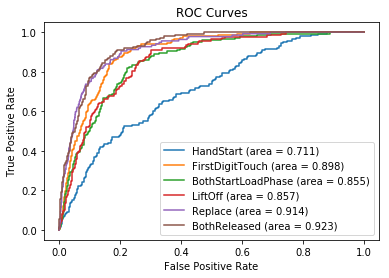

53062 53062
Train subject 12, class HandStart
Train on 1956 samples, validate on 489 samples
Epoch 1/100
1956/1956 [==============================] - 5s 2ms/step - loss: 0.6943 - acc: 0.4990 - val_loss: 0.6907 - val_acc: 0.5481
Epoch 2/100
1956/1956 [==============================] - 3s 2ms/step - loss: 0.6908 - acc: 0.5302 - val_loss: 0.6902 - val_acc: 0.5583
Epoch 3/100
1956/1956 [==============================] - 3s 2ms/step - loss: 0.6926 - acc: 0.5271 - val_loss: 0.6886 - val_acc: 0.5767
Epoch 4/100
1956/1956 [==============================] - 3s 2ms/step - loss: 0.6879 - acc: 0.5322 - val_loss: 0.6843 - val_acc: 0.5603
Epoch 5/100
1956/1956 [==============================] - 3s 2ms/step - loss: 0.6885 - acc: 0.5399 - val_loss: 0.6839 - val_acc: 0.6462
Epoch 6/100
1956/1956 [==============================] - 3s 2ms/step - loss: 0.6881 - acc: 0.5429 - val_loss: 0.6819 - val_acc: 0.6524
Epoch 7/100
1956/1956 [==============================] - 3s 2ms/step - loss: 0.6844 - acc: 0.5573

1956/1956 [==============================] - 3s 2ms/step - loss: 0.4469 - acc: 0.8016 - val_loss: 0.4834 - val_acc: 0.7975
Epoch 61/100
1956/1956 [==============================] - 3s 2ms/step - loss: 0.4440 - acc: 0.7991 - val_loss: 0.4765 - val_acc: 0.7873
Epoch 62/100
1956/1956 [==============================] - 3s 2ms/step - loss: 0.4442 - acc: 0.8052 - val_loss: 0.4798 - val_acc: 0.7832
Epoch 63/100
1956/1956 [==============================] - 3s 2ms/step - loss: 0.4438 - acc: 0.8067 - val_loss: 0.4776 - val_acc: 0.7975
Epoch 64/100
1956/1956 [==============================] - 3s 2ms/step - loss: 0.4478 - acc: 0.8083 - val_loss: 0.4714 - val_acc: 0.7935
Epoch 65/100
1956/1956 [==============================] - 3s 2ms/step - loss: 0.4433 - acc: 0.8037 - val_loss: 0.4879 - val_acc: 0.7935
Epoch 66/100
1956/1956 [==============================] - 3s 2ms/step - loss: 0.4353 - acc: 0.8108 - val_loss: 0.4830 - val_acc: 0.7853
Epoch 67/100
1956/1956 [==============================] - 3s 

1956/1956 [==============================] - 3s 2ms/step - loss: 0.3831 - acc: 0.8471 - val_loss: 0.4029 - val_acc: 0.8384
Epoch 21/100
1956/1956 [==============================] - 3s 2ms/step - loss: 0.3820 - acc: 0.8384 - val_loss: 0.4042 - val_acc: 0.8344
Epoch 22/100
1956/1956 [==============================] - 3s 2ms/step - loss: 0.3879 - acc: 0.8364 - val_loss: 0.4078 - val_acc: 0.8384
Epoch 23/100
1956/1956 [==============================] - 3s 2ms/step - loss: 0.3784 - acc: 0.8497 - val_loss: 0.4154 - val_acc: 0.8323
Epoch 24/100
1956/1956 [==============================] - 3s 2ms/step - loss: 0.3861 - acc: 0.8384 - val_loss: 0.4036 - val_acc: 0.8384
Epoch 25/100
1956/1956 [==============================] - 3s 2ms/step - loss: 0.3747 - acc: 0.8451 - val_loss: 0.4142 - val_acc: 0.8323
Epoch 26/100
1956/1956 [==============================] - 3s 2ms/step - loss: 0.3827 - acc: 0.8359 - val_loss: 0.3961 - val_acc: 0.8364
Epoch 27/100
1956/1956 [==============================] - 3s 

1956/1956 [==============================] - 3s 2ms/step - loss: 0.3064 - acc: 0.8773 - val_loss: 0.3861 - val_acc: 0.8487
Epoch 81/100
1956/1956 [==============================] - 3s 2ms/step - loss: 0.2975 - acc: 0.8855 - val_loss: 0.3780 - val_acc: 0.8548
Epoch 82/100
1956/1956 [==============================] - 3s 2ms/step - loss: 0.2914 - acc: 0.8921 - val_loss: 0.4137 - val_acc: 0.8384
Epoch 83/100
1956/1956 [==============================] - 3s 2ms/step - loss: 0.3030 - acc: 0.8804 - val_loss: 0.3602 - val_acc: 0.8569
Epoch 84/100
1956/1956 [==============================] - 3s 2ms/step - loss: 0.2892 - acc: 0.8906 - val_loss: 0.3618 - val_acc: 0.8589
Epoch 85/100
1956/1956 [==============================] - 3s 2ms/step - loss: 0.2906 - acc: 0.8839 - val_loss: 0.3586 - val_acc: 0.8609
Epoch 86/100
1956/1956 [==============================] - 3s 2ms/step - loss: 0.2955 - acc: 0.8891 - val_loss: 0.4421 - val_acc: 0.8262
Epoch 87/100
1956/1956 [==============================] - 3s 

1956/1956 [==============================] - 3s 2ms/step - loss: 0.4873 - acc: 0.7781 - val_loss: 0.4826 - val_acc: 0.8078
Epoch 40/100
1956/1956 [==============================] - 3s 2ms/step - loss: 0.4726 - acc: 0.7970 - val_loss: 0.4740 - val_acc: 0.8119
Epoch 41/100
1956/1956 [==============================] - 3s 2ms/step - loss: 0.4690 - acc: 0.7858 - val_loss: 0.4646 - val_acc: 0.7607
Epoch 42/100
1956/1956 [==============================] - 3s 2ms/step - loss: 0.4603 - acc: 0.7945 - val_loss: 0.4784 - val_acc: 0.7935
Epoch 43/100
1956/1956 [==============================] - 3s 2ms/step - loss: 0.4533 - acc: 0.8032 - val_loss: 0.4799 - val_acc: 0.7853
Epoch 44/100
1956/1956 [==============================] - 3s 2ms/step - loss: 0.4481 - acc: 0.8113 - val_loss: 0.4518 - val_acc: 0.8139
Epoch 45/100
1956/1956 [==============================] - 3s 2ms/step - loss: 0.4312 - acc: 0.8170 - val_loss: 0.4335 - val_acc: 0.8016
Epoch 46/100
1956/1956 [==============================] - 3s 

1956/1956 [==============================] - 3s 2ms/step - loss: 0.2869 - acc: 0.8926 - val_loss: 0.2973 - val_acc: 0.8916
Epoch 100/100
1956/1956 [==============================] - 3s 2ms/step - loss: 0.2763 - acc: 0.8993 - val_loss: 0.3106 - val_acc: 0.8916
Train on 1956 samples, validate on 489 samples
Epoch 1/100
1956/1956 [==============================] - 3s 2ms/step - loss: 0.3203 - acc: 0.8707 - val_loss: 0.3163 - val_acc: 0.8630
Epoch 2/100
1956/1956 [==============================] - 3s 2ms/step - loss: 0.3206 - acc: 0.8655 - val_loss: 0.3213 - val_acc: 0.8609
Epoch 3/100
1956/1956 [==============================] - 3s 2ms/step - loss: 0.3127 - acc: 0.8712 - val_loss: 0.3136 - val_acc: 0.8712
Epoch 4/100
1956/1956 [==============================] - 3s 2ms/step - loss: 0.2971 - acc: 0.8763 - val_loss: 0.3063 - val_acc: 0.8712
Epoch 5/100
1956/1956 [==============================] - 3s 2ms/step - loss: 0.3013 - acc: 0.8824 - val_loss: 0.3077 - val_acc: 0.8773
Epoch 6/100
1956/1

1956/1956 [==============================] - 3s 2ms/step - loss: 0.2077 - acc: 0.9136 - val_loss: 0.2388 - val_acc: 0.9202
Epoch 60/100
1956/1956 [==============================] - 3s 2ms/step - loss: 0.2066 - acc: 0.9172 - val_loss: 0.2434 - val_acc: 0.9141
Epoch 61/100
1956/1956 [==============================] - 3s 2ms/step - loss: 0.2079 - acc: 0.9151 - val_loss: 0.2509 - val_acc: 0.9039
Epoch 62/100
1956/1956 [==============================] - 3s 2ms/step - loss: 0.2183 - acc: 0.9141 - val_loss: 0.2347 - val_acc: 0.9202
Epoch 63/100
1956/1956 [==============================] - 3s 2ms/step - loss: 0.2105 - acc: 0.9151 - val_loss: 0.2349 - val_acc: 0.9223
Epoch 64/100
1956/1956 [==============================] - 3s 2ms/step - loss: 0.2074 - acc: 0.9126 - val_loss: 0.2378 - val_acc: 0.9162
Epoch 65/100
1956/1956 [==============================] - 3s 2ms/step - loss: 0.2128 - acc: 0.9100 - val_loss: 0.2585 - val_acc: 0.8957
Epoch 66/100
1956/1956 [==============================] - 3s 

1956/1956 [==============================] - 3s 2ms/step - loss: 0.6059 - acc: 0.7577 - val_loss: 0.5921 - val_acc: 0.7730
Epoch 19/100
1956/1956 [==============================] - 3s 2ms/step - loss: 0.5970 - acc: 0.7551 - val_loss: 0.5816 - val_acc: 0.7751
Epoch 20/100
1956/1956 [==============================] - 3s 2ms/step - loss: 0.5807 - acc: 0.7592 - val_loss: 0.5697 - val_acc: 0.7669
Epoch 21/100
1956/1956 [==============================] - 3s 2ms/step - loss: 0.5698 - acc: 0.7694 - val_loss: 0.5541 - val_acc: 0.7873
Epoch 22/100
1956/1956 [==============================] - 3s 2ms/step - loss: 0.5578 - acc: 0.7776 - val_loss: 0.5397 - val_acc: 0.7873
Epoch 23/100
1956/1956 [==============================] - 3s 2ms/step - loss: 0.5408 - acc: 0.7827 - val_loss: 0.5269 - val_acc: 0.7751
Epoch 24/100
1956/1956 [==============================] - 3s 2ms/step - loss: 0.5250 - acc: 0.7914 - val_loss: 0.5150 - val_acc: 0.7751
Epoch 25/100
1956/1956 [==============================] - 3s 

1956/1956 [==============================] - 3s 2ms/step - loss: 0.3128 - acc: 0.8747 - val_loss: 0.3112 - val_acc: 0.8732
Epoch 79/100
1956/1956 [==============================] - 3s 2ms/step - loss: 0.3222 - acc: 0.8732 - val_loss: 0.3116 - val_acc: 0.8773
Epoch 80/100
1956/1956 [==============================] - 3s 2ms/step - loss: 0.3094 - acc: 0.8712 - val_loss: 0.3141 - val_acc: 0.8732
Epoch 81/100
1956/1956 [==============================] - 3s 2ms/step - loss: 0.3073 - acc: 0.8783 - val_loss: 0.3233 - val_acc: 0.8671
Epoch 82/100
1956/1956 [==============================] - 3s 2ms/step - loss: 0.3073 - acc: 0.8773 - val_loss: 0.3051 - val_acc: 0.8753
Epoch 83/100
1956/1956 [==============================] - 3s 2ms/step - loss: 0.3051 - acc: 0.8788 - val_loss: 0.3053 - val_acc: 0.8732
Epoch 84/100
1956/1956 [==============================] - 3s 2ms/step - loss: 0.2975 - acc: 0.8860 - val_loss: 0.3177 - val_acc: 0.8691
Epoch 85/100
1956/1956 [==============================] - 3s 

Epoch 38/100
1956/1956 [==============================] - 3s 2ms/step - loss: 0.2455 - acc: 0.9131 - val_loss: 0.2636 - val_acc: 0.9100
Epoch 39/100
1956/1956 [==============================] - 3s 2ms/step - loss: 0.2301 - acc: 0.9105 - val_loss: 0.3053 - val_acc: 0.8855
Epoch 40/100
1956/1956 [==============================] - 3s 2ms/step - loss: 0.2435 - acc: 0.9182 - val_loss: 0.2338 - val_acc: 0.9223
Epoch 41/100
1956/1956 [==============================] - 3s 2ms/step - loss: 0.2385 - acc: 0.9141 - val_loss: 0.2501 - val_acc: 0.9182
Epoch 42/100
1956/1956 [==============================] - 3s 2ms/step - loss: 0.2357 - acc: 0.9213 - val_loss: 0.2283 - val_acc: 0.9305
Epoch 43/100
1956/1956 [==============================] - 3s 2ms/step - loss: 0.2307 - acc: 0.9182 - val_loss: 0.2267 - val_acc: 0.9264
Epoch 44/100
1956/1956 [==============================] - 3s 2ms/step - loss: 0.2448 - acc: 0.9095 - val_loss: 0.2627 - val_acc: 0.9080
Epoch 45/100
1956/1956 [========================

1956/1956 [==============================] - 3s 2ms/step - loss: 0.1790 - acc: 0.9371 - val_loss: 0.2244 - val_acc: 0.9202
Epoch 99/100
1956/1956 [==============================] - 3s 2ms/step - loss: 0.1731 - acc: 0.9412 - val_loss: 0.2156 - val_acc: 0.9223
Epoch 100/100
1956/1956 [==============================] - 3s 2ms/step - loss: 0.1764 - acc: 0.9366 - val_loss: 0.2374 - val_acc: 0.9162
Test subject 12, class BothStartLoadPhase
Train subject 12, class LiftOff
Train on 1956 samples, validate on 489 samples
Epoch 1/100
1956/1956 [==============================] - 5s 2ms/step - loss: 0.6948 - acc: 0.4990 - val_loss: 0.6945 - val_acc: 0.4601
Epoch 2/100
1956/1956 [==============================] - 3s 2ms/step - loss: 0.6945 - acc: 0.5015 - val_loss: 0.6941 - val_acc: 0.5031
Epoch 3/100
1956/1956 [==============================] - 3s 2ms/step - loss: 0.6931 - acc: 0.5153 - val_loss: 0.6939 - val_acc: 0.4908
Epoch 4/100
1956/1956 [==============================] - 3s 2ms/step - loss: 0

1956/1956 [==============================] - 3s 2ms/step - loss: 0.4712 - acc: 0.7889 - val_loss: 0.5026 - val_acc: 0.7935
Epoch 58/100
1956/1956 [==============================] - 3s 2ms/step - loss: 0.4654 - acc: 0.7940 - val_loss: 0.4912 - val_acc: 0.7955
Epoch 59/100
1956/1956 [==============================] - 3s 2ms/step - loss: 0.4616 - acc: 0.7929 - val_loss: 0.4807 - val_acc: 0.7873
Epoch 60/100
1956/1956 [==============================] - 3s 2ms/step - loss: 0.4578 - acc: 0.7975 - val_loss: 0.4984 - val_acc: 0.7975
Epoch 61/100
1956/1956 [==============================] - 3s 2ms/step - loss: 0.4540 - acc: 0.8016 - val_loss: 0.4732 - val_acc: 0.7914
Epoch 62/100
1956/1956 [==============================] - 3s 2ms/step - loss: 0.4511 - acc: 0.7950 - val_loss: 0.4916 - val_acc: 0.8098
Epoch 63/100
1956/1956 [==============================] - 3s 2ms/step - loss: 0.4433 - acc: 0.8047 - val_loss: 0.4668 - val_acc: 0.8016
Epoch 64/100
1956/1956 [==============================] - 3s 

1956/1956 [==============================] - 3s 2ms/step - loss: 0.3497 - acc: 0.8533 - val_loss: 0.4145 - val_acc: 0.8364
Epoch 18/100
1956/1956 [==============================] - 3s 2ms/step - loss: 0.3492 - acc: 0.8548 - val_loss: 0.4158 - val_acc: 0.8344
Epoch 19/100
1956/1956 [==============================] - 3s 2ms/step - loss: 0.3354 - acc: 0.8604 - val_loss: 0.3976 - val_acc: 0.8487
Epoch 20/100
1956/1956 [==============================] - 3s 2ms/step - loss: 0.3460 - acc: 0.8615 - val_loss: 0.3784 - val_acc: 0.8569
Epoch 21/100
1956/1956 [==============================] - 3s 2ms/step - loss: 0.3409 - acc: 0.8635 - val_loss: 0.4418 - val_acc: 0.8180
Epoch 22/100
1956/1956 [==============================] - 3s 2ms/step - loss: 0.3477 - acc: 0.8599 - val_loss: 0.3689 - val_acc: 0.8630
Epoch 23/100
1956/1956 [==============================] - 3s 2ms/step - loss: 0.3330 - acc: 0.8563 - val_loss: 0.3927 - val_acc: 0.8507
Epoch 24/100
1956/1956 [==============================] - 3s 

1956/1956 [==============================] - 3s 2ms/step - loss: 0.2606 - acc: 0.9039 - val_loss: 0.3603 - val_acc: 0.8834
Epoch 78/100
1956/1956 [==============================] - 3s 2ms/step - loss: 0.2661 - acc: 0.8911 - val_loss: 0.3755 - val_acc: 0.8753
Epoch 79/100
1956/1956 [==============================] - 3s 2ms/step - loss: 0.2560 - acc: 0.9003 - val_loss: 0.4079 - val_acc: 0.8589
Epoch 80/100
1956/1956 [==============================] - 3s 2ms/step - loss: 0.2537 - acc: 0.9008 - val_loss: 0.3324 - val_acc: 0.8834
Epoch 81/100
1956/1956 [==============================] - 3s 2ms/step - loss: 0.2520 - acc: 0.9095 - val_loss: 0.3110 - val_acc: 0.8916
Epoch 82/100
1956/1956 [==============================] - 3s 2ms/step - loss: 0.2557 - acc: 0.8972 - val_loss: 0.3099 - val_acc: 0.8875
Epoch 83/100
1956/1956 [==============================] - 3s 2ms/step - loss: 0.2588 - acc: 0.8993 - val_loss: 0.3503 - val_acc: 0.8855
Epoch 84/100
1956/1956 [==============================] - 3s 

1956/1956 [==============================] - 3s 2ms/step - loss: 0.3573 - acc: 0.8507 - val_loss: 0.4699 - val_acc: 0.7935
Epoch 37/100
1956/1956 [==============================] - 3s 2ms/step - loss: 0.3618 - acc: 0.8492 - val_loss: 0.3725 - val_acc: 0.8671
Epoch 38/100
1956/1956 [==============================] - 3s 2ms/step - loss: 0.3460 - acc: 0.8569 - val_loss: 0.4315 - val_acc: 0.8160
Epoch 39/100
1956/1956 [==============================] - 3s 2ms/step - loss: 0.3457 - acc: 0.8615 - val_loss: 0.3622 - val_acc: 0.8753
Epoch 40/100
1956/1956 [==============================] - 3s 2ms/step - loss: 0.3347 - acc: 0.8655 - val_loss: 0.3704 - val_acc: 0.8569
Epoch 41/100
1956/1956 [==============================] - 3s 2ms/step - loss: 0.3291 - acc: 0.8727 - val_loss: 0.3461 - val_acc: 0.8855
Epoch 42/100
1956/1956 [==============================] - 3s 2ms/step - loss: 0.3237 - acc: 0.8758 - val_loss: 0.3458 - val_acc: 0.8793
Epoch 43/100
1956/1956 [==============================] - 3s 

1956/1956 [==============================] - 3s 2ms/step - loss: 0.1919 - acc: 0.9330 - val_loss: 0.2471 - val_acc: 0.9018
Epoch 97/100
1956/1956 [==============================] - 3s 2ms/step - loss: 0.1940 - acc: 0.9320 - val_loss: 0.2317 - val_acc: 0.9018
Epoch 98/100
1956/1956 [==============================] - 3s 2ms/step - loss: 0.1975 - acc: 0.9274 - val_loss: 0.2452 - val_acc: 0.9018
Epoch 99/100
1956/1956 [==============================] - 3s 2ms/step - loss: 0.1931 - acc: 0.9320 - val_loss: 0.2342 - val_acc: 0.9039
Epoch 100/100
1956/1956 [==============================] - 3s 2ms/step - loss: 0.1910 - acc: 0.9300 - val_loss: 0.2311 - val_acc: 0.9059
Train on 1956 samples, validate on 489 samples
Epoch 1/100
1956/1956 [==============================] - 3s 2ms/step - loss: 0.2488 - acc: 0.9013 - val_loss: 0.3464 - val_acc: 0.8855
Epoch 2/100
1956/1956 [==============================] - 3s 2ms/step - loss: 0.2367 - acc: 0.9095 - val_loss: 0.2852 - val_acc: 0.9059
Epoch 3/100
195

1956/1956 [==============================] - 3s 2ms/step - loss: 0.1838 - acc: 0.9346 - val_loss: 0.2653 - val_acc: 0.9121
Epoch 57/100
1956/1956 [==============================] - 3s 2ms/step - loss: 0.1808 - acc: 0.9376 - val_loss: 0.2945 - val_acc: 0.8998
Epoch 58/100
1956/1956 [==============================] - 3s 2ms/step - loss: 0.1859 - acc: 0.9325 - val_loss: 0.2866 - val_acc: 0.9039
Epoch 59/100
1956/1956 [==============================] - 3s 2ms/step - loss: 0.1772 - acc: 0.9387 - val_loss: 0.2896 - val_acc: 0.9018
Epoch 60/100
1956/1956 [==============================] - 3s 2ms/step - loss: 0.1779 - acc: 0.9330 - val_loss: 0.2377 - val_acc: 0.9202
Epoch 61/100
1956/1956 [==============================] - 3s 2ms/step - loss: 0.1758 - acc: 0.9371 - val_loss: 0.2867 - val_acc: 0.9059
Epoch 62/100
1956/1956 [==============================] - 3s 2ms/step - loss: 0.1719 - acc: 0.9397 - val_loss: 0.2733 - val_acc: 0.9121
Epoch 63/100
1956/1956 [==============================] - 3s 

1956/1956 [==============================] - 3s 2ms/step - loss: 0.6785 - acc: 0.6181 - val_loss: 0.6779 - val_acc: 0.6708
Epoch 16/100
1956/1956 [==============================] - 3s 2ms/step - loss: 0.6771 - acc: 0.6099 - val_loss: 0.6761 - val_acc: 0.6851
Epoch 17/100
1956/1956 [==============================] - 3s 2ms/step - loss: 0.6786 - acc: 0.6115 - val_loss: 0.6742 - val_acc: 0.6912
Epoch 18/100
1956/1956 [==============================] - 3s 2ms/step - loss: 0.6751 - acc: 0.6222 - val_loss: 0.6721 - val_acc: 0.6973
Epoch 19/100
1956/1956 [==============================] - 3s 2ms/step - loss: 0.6739 - acc: 0.6350 - val_loss: 0.6698 - val_acc: 0.6851
Epoch 20/100
1956/1956 [==============================] - 3s 2ms/step - loss: 0.6703 - acc: 0.6508 - val_loss: 0.6679 - val_acc: 0.6626
Epoch 21/100
1956/1956 [==============================] - 3s 2ms/step - loss: 0.6682 - acc: 0.6299 - val_loss: 0.6648 - val_acc: 0.7014
Epoch 22/100
1956/1956 [==============================] - 3s 

1956/1956 [==============================] - 3s 2ms/step - loss: 0.2758 - acc: 0.8937 - val_loss: 0.3256 - val_acc: 0.8773
Epoch 76/100
1956/1956 [==============================] - 3s 2ms/step - loss: 0.2682 - acc: 0.8998 - val_loss: 0.3163 - val_acc: 0.8793
Epoch 77/100
1956/1956 [==============================] - 3s 2ms/step - loss: 0.2742 - acc: 0.8937 - val_loss: 0.3301 - val_acc: 0.8753
Epoch 78/100
1956/1956 [==============================] - 3s 2ms/step - loss: 0.2659 - acc: 0.8972 - val_loss: 0.3269 - val_acc: 0.8773
Epoch 79/100
1956/1956 [==============================] - 3s 2ms/step - loss: 0.2684 - acc: 0.8972 - val_loss: 0.3095 - val_acc: 0.8814
Epoch 80/100
1956/1956 [==============================] - 3s 2ms/step - loss: 0.2601 - acc: 0.9080 - val_loss: 0.3360 - val_acc: 0.8793
Epoch 81/100
1956/1956 [==============================] - 3s 2ms/step - loss: 0.2523 - acc: 0.9110 - val_loss: 0.3046 - val_acc: 0.8896
Epoch 82/100
1956/1956 [==============================] - 3s 

1956/1956 [==============================] - 3s 2ms/step - loss: 0.2192 - acc: 0.9218 - val_loss: 0.2671 - val_acc: 0.9141
Epoch 36/100
1956/1956 [==============================] - 3s 2ms/step - loss: 0.2088 - acc: 0.9233 - val_loss: 0.2234 - val_acc: 0.9346
Epoch 37/100
1956/1956 [==============================] - 3s 2ms/step - loss: 0.2159 - acc: 0.9243 - val_loss: 0.2269 - val_acc: 0.9325
Epoch 38/100
1956/1956 [==============================] - 3s 2ms/step - loss: 0.2005 - acc: 0.9289 - val_loss: 0.2123 - val_acc: 0.9305
Epoch 39/100
1956/1956 [==============================] - 3s 2ms/step - loss: 0.2098 - acc: 0.9259 - val_loss: 0.2194 - val_acc: 0.9346
Epoch 40/100
1956/1956 [==============================] - 3s 2ms/step - loss: 0.2106 - acc: 0.9233 - val_loss: 0.2161 - val_acc: 0.9366
Epoch 41/100
1956/1956 [==============================] - 3s 2ms/step - loss: 0.2058 - acc: 0.9238 - val_loss: 0.2294 - val_acc: 0.9325
Epoch 42/100
1956/1956 [==============================] - 3s 

1956/1956 [==============================] - 3s 2ms/step - loss: 0.1669 - acc: 0.9371 - val_loss: 0.2270 - val_acc: 0.9325
Epoch 96/100
1956/1956 [==============================] - 3s 2ms/step - loss: 0.1614 - acc: 0.9376 - val_loss: 0.2246 - val_acc: 0.9366
Epoch 97/100
1956/1956 [==============================] - 3s 2ms/step - loss: 0.1638 - acc: 0.9427 - val_loss: 0.2294 - val_acc: 0.9325
Epoch 98/100
1956/1956 [==============================] - 3s 2ms/step - loss: 0.1621 - acc: 0.9397 - val_loss: 0.2229 - val_acc: 0.9387
Epoch 99/100
1956/1956 [==============================] - 3s 2ms/step - loss: 0.1632 - acc: 0.9443 - val_loss: 0.2211 - val_acc: 0.9387
Epoch 100/100
1956/1956 [==============================] - 3s 2ms/step - loss: 0.1642 - acc: 0.9361 - val_loss: 0.2183 - val_acc: 0.9387
Test subject 12, class BothReleased
HandStart AUC score = 0.750
FirstDigitTouch AUC score = 0.864
BothStartLoadPhase AUC score = 0.835
LiftOff AUC score = 0.783
Replace AUC score = 0.907
BothRelea

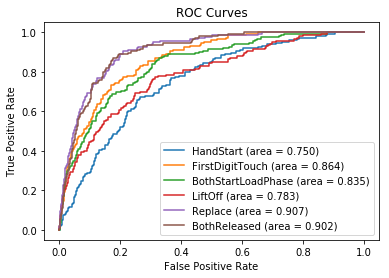

In [17]:


models = []
for i in range(N_LABELS):
    models.append(init_cnn(WINDOW_SIZE))

for subject in TRAIN_SUBJECTS:
    prediction_total = []
    test_data_total = []
    train_data_paths = glob(TRAIN_DATA_PATH % (subject))

    
    x_raw, y_raw = read_training_data(train_data_paths)
    
    x_raw, _ = preprocess_data(x_raw, WINDOW_SIZE, SUBSAMPLE)
#     y_train = y_raw[::SUBSAMPLE]

    x_train, x_test, y_train, y_test = train_test_split(x_raw, y_raw[::SUBSAMPLE], test_size=0.33, shuffle=False)
    x_train, _, y_train, _ = train_test_split(x_train, y_train, test_size=0.0001, shuffle=True)
    print(len(x_test), len(y_test))
    
    for i in range(N_LABELS):
        model = init_cnn(WINDOW_SIZE)
        
        balanced_x_train, balanced_y_train = remove_imbalance(x_train, y_train[:,i])
        

            
        train_labels = to_categorical(balanced_y_train, num_classes = None)
                
        print('Train subject %d, class %s' % (subject, COLUMNS[i]))
        
        x = [balanced_x_train[j::2] for j in range(2)]
        y = [train_labels[j::2] for j in range(2)]
        result = np.array([])
        for sample_x, sample_y in zip(x, y):
            model.fit(np.array(sample_x), np.array(sample_y), verbose=1, validation_split=0.2, epochs=EPOCHS)
        
        
        
#         test_labels = to_categorical(y_test[:,i], num_classes = None)
                
        print('Test subject %d, class %s' % (subject, COLUMNS[i]))                
        predictions = predict_on_sub(x_test, model, SPLIT_SIZE, BATCH_SIZE)
        
        test_data_total.append(y_test[:,i][1000::BATCH_SIZE])
        prediction_total.append(predictions)
        
    multiple_metric_auc_score(prediction_total, test_data_total, True)
        

HandStart AUC score = 0.750
FirstDigitTouch AUC score = 0.864
BothStartLoadPhase AUC score = 0.835
LiftOff AUC score = 0.783
Replace AUC score = 0.907
BothReleased AUC score = 0.902


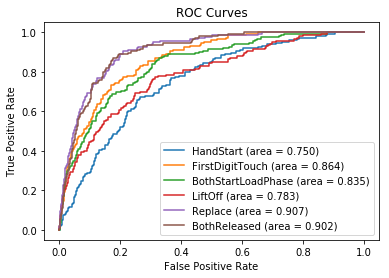

In [18]:
multiple_metric_auc_score(prediction_total, test_data_total, True)